In [3]:
# import packages
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import math
from scipy import stats
from scipy import optimize
from scipy import interpolate
from scipy.optimize import curve_fit
import numpy as np
import glob

### Functions

In [4]:
def rip_in_acs_data(fn):
    """
    Inputs: path to raw ACS csv file
    Outputs: [1] a wavelengths, [2] c wavelengths, [3] a data, [4] c data
    
    Wavelength variables are 1D np arrays of wavelengths
    Data variables are 2D np arrays, where each 1D array inside is a timepoint across all wavelengths
    
    (c) Patrick Gray
    """
    acs_data = pd.read_csv(fn)
    a_wavelengths = acs_data.iloc[:1][' a'].apply(lambda x: np.fromstring(
                               x.replace(' 1/m\tlambda=',''), sep=' ')).iloc[0]
    c_wavelengths = acs_data.iloc[:1][' c'].apply(lambda x: np.fromstring(
                               x.replace(' 1/m\tlambda=',''), sep=' ')).iloc[0]
    acs_data = acs_data.iloc[1:]

    acs_data['c_np'] = acs_data[' c'].apply(lambda x: np.fromstring(
                               x.replace('[','')
                                .replace(']',''), sep=' '))

    acs_data['a_np'] = acs_data[' a'].apply(lambda x: np.fromstring(
                               x.replace('[','')
                                .replace(']',''), sep=' '))

    c_stack = []

    for i in range(0,len(acs_data)):
        c_stack.append(acs_data.iloc[i]['c_np'])
    c_stack = np.stack(c_stack)
    c_stack.shape


    a_stack = []

    for i in range(0,len(acs_data)):
        a_stack.append(acs_data.iloc[i]['a_np'])
    a_stack = np.stack(a_stack)
    a_stack.shape

    return(a_wavelengths, c_wavelengths, a_stack, c_stack)

In [5]:
def costFun_RTSC(deltaT, ap, bp, psiT, iNIR, iref):
    """
    Function from Emmanuel Boss improved by Nils Haëntjens
    Ported to python by Michael Chen
    """
    cost = sum(abs(ap[iNIR] - np.multiply(psiT[iNIR], deltaT) - np.multiply(np.divide((ap[iref]-np.multiply(psiT[iref], deltaT)), bp[iref]), bp[iNIR])))
    return cost


In [6]:
def costfun_TSD(x, a, psiT, psiS, wl):
    """
    Function from Emmanuel Boss / Nils Haëntjens
    Ported to python by Michael Chen
    """
    # Force Temperature, Salinity, and Slope
    
    # For readability, define terms seperately
    # Structure: cost = sum(np.square(a - term1 - term2 - term3))
    
    term1 = np.multiply(psiT,x[0])
    term2 = np.multiply(psiS,x[1])
    
    exp_term_inside = np.multiply(-x[3],np.subtract(wl,450)) #see term3 and exp_term for structure
    exp_term = np.exp(exp_term_inside)
    term3 = np.multiply(x[2],exp_term)
    
    cost = sum(np.square(a - term1 - term2 - term3))
    return cost


In [7]:
def TemperatureAndSalinityDependence(a, c, wl):
    """
    Assumes that a and c have been splined to be on the same wvelengths
    
    Sullivan et al. 2006 values
    
    Function from Emmanuel Boss / Nils Haëntjens
    Ported to python by Michael Chen
    """

    psi_wl = np.array([400,402,404,406,408,410,412,414,416,418,420,422,424,426,428,430,432,434,436,438,440,442,444,446,448,450,452,454,456,458,460,462,464,466,468,470,472,474,476,478,480,482,484,486,488,490,492,494,496,498,500,502,504,506,508,510,512,514,516,518,520,522,524,526,528,530,532,534,536,538,540,542,544,546,548,550,552,554,556,558,560,562,564,566,568,570,572,574,576,578,580,582,584,586,588,590,592,594,596,598,600,602,604,606,608,610,612,614,616,618,620,622,624,626,628,630,632,634,636,638,640,642,644,646,648,650,652,654,656,658,660,662,664,666,668,670,672,674,676,678,680,682,684,686,688,690,692,694,696,698,700,702,704,706,708,710,712,714,716,718,720,722,724,726,728,730,732,734,736,738,740,742,744,746,748,750])
    psiT = np.array([0.0001,0.0001,0.0001,0.0001,0,0,0,0.0001,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0001,0.0001,0.0001,0.0002,0.0003,0.0003,0.0004,0.0005,0.0006,0.0006,0.0007,0.0008,0.0009,0.001,0.001,0.001,0.001,0.001,0.0009,0.0009,0.0008,0.0007,0.0006,0.0006,0.0005,0.0004,0.0003,0.0003,0.0002,0.0001,0.0001,0,0,0,0,0,0,0,0,0,0.0001,0.0001,0.0001,0.0002,0.0002,0.0002,0.0001,0.0001,0.0001,0,0,-0.0001,-0.0001,-0.0001,-0.0001,-0.0001,-0.0001,0,0,0.0001,0.0002,0.0003,0.0005,0.0007,0.0009,0.0013,0.0017,0.0021,0.0026,0.0032,0.0038,0.0045,0.0054,0.0063,0.0073,0.0083,0.0094,0.0104,0.0113,0.0121,0.0128,0.0133,0.0136,0.0136,0.0133,0.0129,0.0124,0.0116,0.0107])
    c_psiS = np.array([-1.0e-05,-2.0e-05,-2.0e-05,-2.0e-05,-2.0e-05,-2.0e-05,-2.0e-05,-2.0e-05,-2.0e-05,-3.0e-05,-3.0e-05,-3.0e-05,-3.0e-05,-3.0e-05,-3.0e-05,-3.0e-05,-3.0e-05,-3.0e-05,-3.0e-05,-4.0e-05,-4.0e-05,-4.0e-05,-4.0e-05,-4.0e-05,-4.0e-05,-4.0e-05,-4.0e-05,-4.0e-05,-4.0e-05,-4.0e-05,-4.0e-05,-4.0e-05,-4.0e-05,-4.0e-05,-4.0e-05,-4.0e-05,-4.0e-05,-4.0e-05,-4.0e-05,-4.0e-05,-4.0e-05,-4.0e-05,-4.0e-05,-4.0e-05,-4.0e-05,-4.0e-05,-4.0e-05,-4.0e-05,-4.0e-05,-4.0e-05,-4.0e-05,-4.0e-05,-4.0e-05,-4.0e-05,-4.0e-05,-4.0e-05,-4.0e-05,-4.0e-05,-4.0e-05,-4.0e-05,-4.0e-05,-4.0e-05,-4.0e-05,-4.0e-05,-4.0e-05,-4.0e-05,-4.0e-05,-4.0e-05,-4.0e-05,-4.0e-05,-4.0e-05,-4.0e-05,-4.0e-05,-4.0e-05,-4.0e-05,-4.0e-05,-4.0e-05,-4.0e-05,-4.0e-05,-4.0e-05,-4.0e-05,-4.0e-05,-4.0e-05,-4.0e-05,-4.0e-05,-4.0e-05,-5.0e-05,-5.0e-05,-5.0e-05,-5.0e-05,-5.0e-05,-5.0e-05,-5.0e-05,-5.0e-05,-5.0e-05,-5.0e-05,-5.0e-05,-5.0e-05,-5.0e-05,-4.0e-05,-3.0e-05,-3.0e-05,-2.0e-05,-1.0e-05,0,1.0e-05,1.0e-05,2.0e-05,2.0e-05,2.0e-05,2.0e-05,2.0e-05,2.0e-05,2.0e-05,2.0e-05,2.0e-05,2.0e-05,1.0e-05,1.0e-05,1.0e-05,1.0e-05,0,0,0,-1.0e-05,-1.0e-05,-1.0e-05,-1.0e-05,-2.0e-05,-2.0e-05,-2.0e-05,-2.0e-05,-2.0e-05,-2.0e-05,-2.0e-05,-2.0e-05,-2.0e-05,-3.0e-05,-4.0e-05,-5.0e-05,-6.0e-05,-6.0e-05,-8.0e-05,-9.0e-05,-0.00010,-0.00011,-0.00013,-0.00014,-0.00016,-0.00017,-0.00018,-0.00019,-0.00020,-0.00021,-0.00022,-0.00022,-0.00023,-0.00023,-0.00023,-0.00024,-0.00024,-0.00024,-0.00024,-0.00022,-0.00021,-0.00017,-0.00012,-6.0e-05,2.0e-05,0.00012,0.00022,0.00031,0.00041,0.00049,0.00056,0.00062])
    a_psiS = np.array([3.0e-05,3.0e-05,3.0e-05,4.0e-05,4.0e-05,4.0e-05,4.0e-05,4.0e-05,4.0e-05,4.0e-05,4.0e-05,3.0e-05,3.0e-05,3.0e-05,3.0e-05,3.0e-05,3.0e-05,3.0e-05,3.0e-05,3.0e-05,2.0e-05,2.0e-05,2.0e-05,2.0e-05,2.0e-05,2.0e-05,2.0e-05,2.0e-05,2.0e-05,2.0e-05,2.0e-05,2.0e-05,2.0e-05,2.0e-05,2.0e-05,1.0e-05,1.0e-05,1.0e-05,1.0e-05,1.0e-05,1.0e-05,1.0e-05,1.0e-05,1.0e-05,1.0e-05,1.0e-05,1.0e-05,1.0e-05,1.0e-05,1.0e-05,1.0e-05,1.0e-05,1.0e-05,1.0e-05,1.0e-05,1.0e-05,1.0e-05,1.0e-05,1.0e-05,1.0e-05,1.0e-05,1.0e-05,1.0e-05,1.0e-05,1.0e-05,1.0e-05,1.0e-05,1.0e-05,1.0e-05,1.0e-05,1.0e-05,1.0e-05,1.0e-05,1.0e-05,1.0e-05,0,0,0,0,0,0,0,0,0,0,-1.0e-05,-1.0e-05,-1.0e-05,-1.0e-05,-1.0e-05,-1.0e-05,-1.0e-05,-1.0e-05,-1.0e-05,-1.0e-05,-1.0e-05,-1.0e-05,-1.0e-05,-1.0e-05,-1.0e-05,0,1.0e-05,2.0e-05,3.0e-05,3.0e-05,4.0e-05,5.0e-05,5.0e-05,6.0e-05,6.0e-05,6.0e-05,6.0e-05,6.0e-05,6.0e-05,6.0e-05,5.0e-05,5.0e-05,5.0e-05,5.0e-05,4.0e-05,4.0e-05,4.0e-05,4.0e-05,3.0e-05,3.0e-05,3.0e-05,2.0e-05,2.0e-05,2.0e-05,2.0e-05,2.0e-05,2.0e-05,2.0e-05,2.0e-05,1.0e-05,1.0e-05,1.0e-05,0,0,-1.0e-05,-2.0e-05,-3.0e-05,-4.0e-05,-6.0e-05,-7.0e-05,-8.0e-05,-9.0e-05,-0.00011,-0.00012,-0.00014,-0.00015,-0.00016,-0.00017,-0.00018,-0.00019,-0.00020,-0.00020,-0.00020,-0.00021,-0.00021,-0.00021,-0.00021,-0.00021,-0.00020,-0.00017,-0.00013,-8.0e-05,-1.0e-05,7.0e-05,0.00016,0.00026,0.00037,0.00046,0.00054,0.00061,0.00067])
    
    # Interpolate Sullivan values on the current ACS
    psiInterpT = interpolate.interp1d(psi_wl, psiT, kind='cubic', fill_value="extrapolate") # Defines a function to interpolate the pre-defined psiT to the number of input wl values
    psiT = psiInterpT(wl) # Apply the function to yield the interpolated psiT
    
    
    psiInterpS_a = interpolate.interp1d(psi_wl, a_psiS, kind='cubic', fill_value="extrapolate") # Defines a function to interpolate the pre-defined a_psiS to the number of input wl values
    a_psiS = psiInterpS_a(wl) # Apply the function to yield the interpolated psiT
    
    
    psiInterpS_c = interpolate.interp1d(psi_wl, c_psiS, kind='cubic', fill_value="extrapolate") # Defines a function to interpolate the pre-defined c_psiS to the number of input wl values
    c_psiS = psiInterpS_c(wl) # Apply the function to yield the interpolated psiT
    
    
    # Center psiS on 0 instead of +/- 0.001
    under590 = [idx for idx, element in enumerate(wl) if element<=590]
    a_psiS = a_psiS - np.median(np.array([a_psiS[i] for i in under590])) # median of a_psiS <= 590 nm
    c_psiS = c_psiS - np.median(np.array([c_psiS[i] for i in under590])) # median of c_psiS <= 590 nm

    
    # Wavelength selection
    iwl = [idx for idx, element in enumerate(wl) if element>=450]
    
    # Init minimization parameters
    deltaT = 10
    deltaS = 20
    amp_index = [idx for idx, element in enumerate(a) if np.all(np.isfinite(element))][0] #First timepoint with non-nan values
    amp = a[amp_index,20] # Initialize with the 20th wavelength at the given index
    slope = 0.014
    
    # Init loop
    n = np.size(a,0)
    a_deltaT = np.asarray([np.nan for x in range(len(a))])
    a_deltaS = np.asarray([np.nan for x in range(len(a))])
    a_amp = np.asarray([np.nan for x in range(len(a))])
    c_deltaT = np.asarray([np.nan for x in range(len(a))])
    c_deltaS = np.asarray([np.nan for x in range(len(a))])
    c_amp = np.asarray([np.nan for x in range(len(a))])
    a_slope = np.asarray([np.nan for x in range(len(a))])
    c_slope = np.asarray([np.nan for x in range(len(a))])
    
    # Run minimization
    for k in range(n):
      # Force Temperature, Salinity, and Slope
        
        # Minimize absorption
        x = optimize.fmin(costfun_TSD, x0=[deltaT, deltaS, amp, slope], 
                          args=(a[k,iwl], psiT[iwl], a_psiS[iwl], wl[iwl]), 
                                  xtol=1e-8, ftol=1e-8, maxiter=20000000, maxfun=20000, 
                                  full_output=0, disp=0, retall=0, callback=None, initial_simplex=None)
        
        a_deltaT[k], a_deltaS[k], a_amp[k], a_slope[k] = x[0], x[1], x[2], x[3]
        
        # Minimize attenuation
        x = optimize.fmin(costfun_TSD, x0=[deltaT, deltaS, amp, slope], 
                          args=(c[k,iwl], psiT[iwl], c_psiS[iwl], wl[iwl]), 
                                  xtol=1e-8, ftol=1e-8, maxiter=20000000, maxfun=20000, 
                                  full_output=0, disp=0, retall=0, callback=None, initial_simplex=None)
        
        c_deltaT[k], c_deltaS[k], c_amp[k], c_slope[k] = x[0], x[1], x[2], x[3]
        
    # Apply correction (psiT[None,:] * deltaT[:,None])
    a_corr = a - (psiT[None,:] * a_deltaT[:,None]) - (a_psiS[None,:] * a_deltaS[:,None])
    c_corr = c - (psiT[None,:] * c_deltaT[:,None]) - (c_psiS[None,:] * c_deltaS[:,None])
    
    return(a_corr,c_corr)

In [8]:
def ResidualTemperatureAndScatteringCorrection(ap, cp, wl):
    """
  Function from Emmanuel Boss improved by Nils Haëntjens
  # ported to python by Patrick Gray and Michael Chen

  # Throughout the comments: 
  # - Let N be the number of reads/timepoints (the "length" of the input ap and cp matrices)
  # - Let M be the number of wavelengths (the "width" of the input ap and cp matrices)
    
  # Sullivan et al. 2006 values
    """  
    # Pre-define psiT values for given wavelengths
    psi_wl = [400,402,404,406,408,410,412,414,416,418,420,422,424,426,428,430,432,434,436,438,440,442,444,446,448,450,452,454,456,458,460,462,464,466,468,470,472,474,476,478,480,482,484,486,488,490,492,494,496,498,500,502,504,506,508,510,512,514,516,518,520,522,524,526,528,530,532,534,536,538,540,542,544,546,548,550,552,554,556,558,560,562,564,566,568,570,572,574,576,578,580,582,584,586,588,590,592,594,596,598,600,602,604,606,608,610,612,614,616,618,620,622,624,626,628,630,632,634,636,638,640,642,644,646,648,650,652,654,656,658,660,662,664,666,668,670,672,674,676,678,680,682,684,686,688,690,692,694,696,698,700,702,704,706,708,710,712,714,716,718,720,722,724,726,728,730,732,734,736,738,740,742,744,746,748,750]
    psiT = [0.0001,0.0001,0.0001,0.0001,0,0,0,0.0001,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0001,0.0001,0.0001,0.0002,0.0003,0.0003,0.0004,0.0005,0.0006,0.0006,0.0007,0.0008,0.0009,0.001,0.001,0.001,0.001,0.001,0.0009,0.0009,0.0008,0.0007,0.0006,0.0006,0.0005,0.0004,0.0003,0.0003,0.0002,0.0001,0.0001,0,0,0,0,0,0,0,0,0,0.0001,0.0001,0.0001,0.0002,0.0002,0.0002,0.0001,0.0001,0.0001,0,0,-0.0001,-0.0001,-0.0001,-0.0001,-0.0001,-0.0001,0,0,0.0001,0.0002,0.0003,0.0005,0.0007,0.0009,0.0013,0.0017,0.0021,0.0026,0.0032,0.0038,0.0045,0.0054,0.0063,0.0073,0.0083,0.0094,0.0104,0.0113,0.0121,0.0128,0.0133,0.0136,0.0136,0.0133,0.0129,0.0124,0.0116,0.0107]
    
    psiInterp = interpolate.interp1d(psi_wl, psiT, kind='cubic', fill_value="extrapolate") # Defines a function to interpolate the pre-defined psiT to the number of input wl values
    psiT = psiInterp(wl) # Apply the function to yield the interpolated psiT

        
    # Find Near Infrared & references
    iNIR = [idx for idx, element in enumerate(wl) if 710<=element<=750]  # indices in wl for optimization (710 to 750nm)
    if len(iNIR)==0:
        raise('Unable to perform correction as no wavelength available in NIR.')
    
    # Find nearest wavelength to greater than 715 nm to use as reference for correction
    iref = [idx for idx, element in enumerate(wl) if 715<=element][0] # returns index of iref, not the actual value
    
    # If ACS spectrum does not go up to 730 nm take the closest wavelength to 730 nm
    if iref == None:
        iref = wl.index(max(wl)) # works as there is data in iNIR so lowest wavelength is 710 (also returns index, not value)
        
    # Initialize output arrays
    deltaT = np.asarray([np.nan for x in range(len(ap))]) # Create an empty matrix of length N
        
    # Init routine parameters
    bp = cp - ap; # Calculate scattering fraction
        
    # Run minimization routine on good spectrum only
    sel = [idx for idx, element in enumerate(ap) if np.all(np.isfinite(element))] # Return the indices of all timepoints with non-NAN, non-infinite values
    
    for k in sel: # For each timepoint, run the minimization routing
        deltaT[k] = optimize.fmin(costFun_RTSC, x0=0, args=(ap[k,:], bp[k,:], psiT, iNIR, iref), 
                                  xtol=1e-8, ftol=1e-8, maxiter=20000000, maxfun=20000, 
                                  full_output=0, disp=0, retall=0, callback=None, initial_simplex=None)

    
    # For readability, define the terms of the scattering correction separately here
    scattcorr_div_top = ap[:,iref] - np.multiply(psiT[iref],deltaT) # Numerator (1xN matrix): For all readings at the reference lambda, subtract the temp-corrected psiT
    scattcorr_div_bottom = bp[:,iref] # Denominator (1xN matrix): the scattering value of all readings at the reference lambda
    scattcorr_divided = np.divide(scattcorr_div_top,scattcorr_div_bottom) # 1xN matrix
   

    # (NxM matrix) - (1xM matrix * N*1 matrix) - (1xN matrix * N*M matrix)
    ap_corr = ap - (psiT[None,:] * deltaT[:,None]) - (scattcorr_divided[:,None] * bp) # Indexing notation enables matrix multiplication
    cp_corr = cp - (psiT[None,:] * deltaT[:,None])

        
    return(ap_corr, cp_corr)

In [9]:
# Interpolate the c data to a wavelengths

def InterpCtoA(c_data,c_wav,a_wav):
    """
    Cubic spline interpolation of c data to a wavelengths.
    """
    for i in range(len(c_data)):
        interp_c_to_a = interpolate.interp1d(c_wav, c_data[i], kind='cubic', fill_value="extrapolate") # Defines a function to interpolate the pre-defined psiT to the number of input wl values
        c_data[i] = interp_c_to_a(a_wav)
    return c_data


## bb/b time-series analysis

### Read in data
#### Interpolate c wavelengths

In [10]:
# Read in data for all timepoints
a_totals = ['a_tot_0930', 'a_tot_1130', 'a_tot_1330', 'a_tot_1530', 'a_tot_1730', 'a_tot_1930', 'a_tot_2130'] 
c_totals = ['c_tot_0930', 'c_tot_1130', 'c_tot_1330', 'c_tot_1530', 'c_tot_1730', 'c_tot_1930', 'c_tot_2130'] 

a_filts = ['a_filt_0930', 'a_filt_1130', 'a_filt_1330', 'a_filt_1530', 'a_filt_1730', 'a_filt_1930', 'a_filt_2130'] 
c_filts = ['c_filt_0930', 'c_filt_1130', 'c_filt_1330', 'c_filt_1530', 'c_filt_1730', 'c_filt_1930', 'c_filt_2130'] 

a_DI = ['a_DI_0930', 'a_DI_2130']
c_DI = ['c_DI_0930', 'c_DI_2130']

for i in range(7):
    a_wav, _, globals()[a_totals[i]], _ = rip_in_acs_data(sorted(glob.glob('d_raw/ACS/BYOB_ACS_a_TOT_*.csv'))[i])
    _, c_wav, _, globals()[c_totals[i]] = rip_in_acs_data(sorted(glob.glob('d_raw/ACS/BYOB_ACS_c_TOT_*.csv'))[i])
    a_wav, _, globals()[a_filts[i]], _ = rip_in_acs_data(sorted(glob.glob('d_raw/ACS/BYOB_ACS_a_FIL_*.csv'))[i])
    _, c_wav, _, globals()[c_filts[i]] = rip_in_acs_data(sorted(glob.glob('d_raw/ACS/BYOB_ACS_c_FIL_*.csv'))[i])
    
for i in range(2):
    a_wav, _, globals()[a_DI[i]], _ = rip_in_acs_data(sorted(glob.glob('d_raw/ACS/BYOB_ACS_a_DI_*.csv'))[i])
    _, c_wav, _, globals()[c_DI[i]] = rip_in_acs_data(sorted(glob.glob('d_raw/ACS/BYOB_ACS_c_DI_*.csv'))[i])
    
# Interpolate c data to a wavelengths
for i in range(7):
    globals()[c_totals[i]] = InterpCtoA(globals()[c_totals[i]], c_wav, a_wav)
    globals()[c_filts[i]] = InterpCtoA(globals()[c_filts[i]], c_wav, a_wav)
    
for i in range(2):
    globals()[c_DI[i]] = InterpCtoA(globals()[c_DI[i]], c_wav, a_wav)

#### Summary stats

In [11]:
# Take summary stats for all dataframes
for i in range(7):
    # Medians: append "_med" to filenames
    globals()[a_totals[i]+'_med'] = np.array(np.median(globals()[a_totals[i]],axis=0))
    globals()[c_totals[i]+'_med'] = np.array(np.median(globals()[c_totals[i]],axis=0))
    globals()[a_filts[i]+'_med'] = np.array(np.median(globals()[a_filts[i]],axis=0))
    globals()[c_filts[i]+'_med'] = np.array(np.median(globals()[c_filts[i]],axis=0))
    
    # Stdevs: append "_std" to filenames
    globals()[a_totals[i]+'_std'] = np.array(np.std(globals()[a_totals[i]],axis=0))
    globals()[c_totals[i]+'_std'] = np.array(np.std(globals()[c_totals[i]],axis=0))
    globals()[a_filts[i]+'_std'] = np.array(np.std(globals()[a_filts[i]],axis=0))
    globals()[c_filts[i]+'_std'] = np.array(np.std(globals()[c_filts[i]],axis=0))
    
for i in range(2):
    globals()[a_DI[i]+'_med'] = np.array(np.median(globals()[a_DI[i]],axis=0))
    globals()[c_DI[i]+'_med'] = np.array(np.median(globals()[c_DI[i]],axis=0))

    globals()[a_DI[i]+'_std'] = np.array(np.std(globals()[a_DI[i]],axis=0))
    globals()[c_DI[i]+'_std'] = np.array(np.std(globals()[c_DI[i]],axis=0))

### Examine the filtrate/CDOM samples
##### Check the 9:30 vs the 21:30 DIW samples

In [12]:
# 9:30 DIW samples
a_filt_0930_corr1 = a_filt_0930_med - a_DI_0930_med
c_filt_0930_corr1 = c_filt_0930_med - c_DI_0930_med

a_filt_1130_corr1 = a_filt_1130_med - a_DI_0930_med
c_filt_1130_corr1 = c_filt_1130_med - c_DI_0930_med

a_filt_1330_corr1 = a_filt_1330_med - a_DI_0930_med
c_filt_1330_corr1 = c_filt_1330_med - c_DI_0930_med

a_filt_1530_corr1 = a_filt_1530_med - a_DI_0930_med
c_filt_1530_corr1 = c_filt_1530_med - c_DI_0930_med

a_filt_1730_corr1 = a_filt_1730_med - a_DI_0930_med
c_filt_1730_corr1 = c_filt_1730_med - c_DI_0930_med

a_filt_1930_corr1 = a_filt_1930_med - a_DI_0930_med
c_filt_1930_corr1 = c_filt_1930_med - c_DI_0930_med

a_filt_2130_corr1 = a_filt_2130_med - a_DI_0930_med
c_filt_2130_corr1 = c_filt_2130_med - c_DI_0930_med

# Temperature and Salinity correct the DI subtracted filtered data
[a_filt_0930_corr1,c_filt_0930_corr1] = TemperatureAndSalinityDependence(a_filt_0930_corr1[None,:], c_filt_0930_corr1[None,:], a_wav)
[a_filt_1130_corr1,c_filt_1130_corr1] = TemperatureAndSalinityDependence(a_filt_1130_corr1[None,:], c_filt_1130_corr1[None,:], a_wav)
[a_filt_1330_corr1,c_filt_1330_corr1] = TemperatureAndSalinityDependence(a_filt_1330_corr1[None,:], c_filt_1330_corr1[None,:], a_wav)
[a_filt_1530_corr1,c_filt_1530_corr1] = TemperatureAndSalinityDependence(a_filt_1530_corr1[None,:], c_filt_1530_corr1[None,:], a_wav)
[a_filt_1730_corr1,c_filt_1730_corr1] = TemperatureAndSalinityDependence(a_filt_1730_corr1[None,:], c_filt_1730_corr1[None,:], a_wav)
[a_filt_1930_corr1,c_filt_1930_corr1] = TemperatureAndSalinityDependence(a_filt_1930_corr1[None,:], c_filt_1930_corr1[None,:], a_wav)
[a_filt_2130_corr1,c_filt_2130_corr1] = TemperatureAndSalinityDependence(a_filt_2130_corr1[None,:], c_filt_2130_corr1[None,:], a_wav)

a_cdom_correcteds1 = [a_filt_0930_corr1,a_filt_1130_corr1,a_filt_1330_corr1,a_filt_1530_corr1,a_filt_1730_corr1,a_filt_1930_corr1,a_filt_2130_corr1]
a_cdom_uncorrecteds = [a_filt_0930_med,a_filt_1130_med,a_filt_1330_med,a_filt_1530_med,a_filt_1730_med,a_filt_1930_med,a_filt_2130_med]

c_cdom_correcteds1 = [c_filt_0930_corr1,c_filt_1130_corr1,c_filt_1330_corr1,c_filt_1530_corr1,c_filt_1730_corr1,c_filt_1930_corr1,c_filt_2130_corr1]
c_cdom_uncorrecteds = [c_filt_0930_med,c_filt_1130_med,c_filt_1330_med,c_filt_1530_med,c_filt_1730_med,c_filt_1930_med,c_filt_2130_med]

IndexError: list index out of range

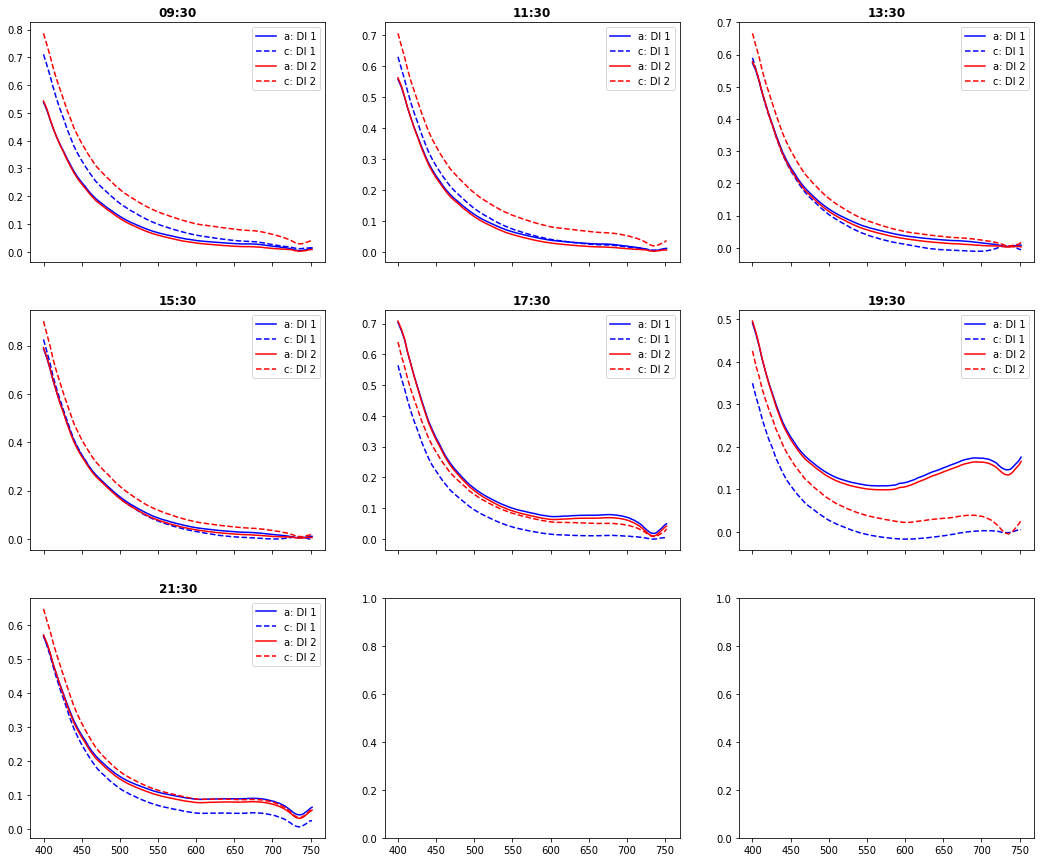

In [13]:
# 21:30 DIW samples
a_filt_0930_corr2 = a_filt_0930_med - a_DI_2130_med
c_filt_0930_corr2 = c_filt_0930_med - c_DI_2130_med

a_filt_1130_corr2 = a_filt_1130_med - a_DI_2130_med
c_filt_1130_corr2 = c_filt_1130_med - c_DI_2130_med

a_filt_1330_corr2 = a_filt_1330_med - a_DI_2130_med
c_filt_1330_corr2 = c_filt_1330_med - c_DI_2130_med

a_filt_1530_corr2 = a_filt_1530_med - a_DI_2130_med
c_filt_1530_corr2 = c_filt_1530_med - c_DI_2130_med

a_filt_1730_corr2 = a_filt_1730_med - a_DI_2130_med
c_filt_1730_corr2 = c_filt_1730_med - c_DI_2130_med

a_filt_1930_corr2 = a_filt_1930_med - a_DI_2130_med
c_filt_1930_corr2 = c_filt_1930_med - c_DI_2130_med

a_filt_2130_corr2 = a_filt_2130_med - a_DI_2130_med
c_filt_2130_corr2 = c_filt_2130_med - c_DI_2130_med

# Temperature and Salinity correct the DIW-subtracted filtered data
[a_filt_0930_corr2,c_filt_0930_corr2] = TemperatureAndSalinityDependence(a_filt_0930_corr2[None,:], c_filt_0930_corr2[None,:], a_wav)
[a_filt_1130_corr2,c_filt_1130_corr2] = TemperatureAndSalinityDependence(a_filt_1130_corr2[None,:], c_filt_1130_corr2[None,:], a_wav)
[a_filt_1330_corr2,c_filt_1330_corr2] = TemperatureAndSalinityDependence(a_filt_1330_corr2[None,:], c_filt_1330_corr2[None,:], a_wav)
[a_filt_1530_corr2,c_filt_1530_corr2] = TemperatureAndSalinityDependence(a_filt_1530_corr2[None,:], c_filt_1530_corr2[None,:], a_wav)
[a_filt_1730_corr2,c_filt_1730_corr2] = TemperatureAndSalinityDependence(a_filt_1730_corr2[None,:], c_filt_1730_corr2[None,:], a_wav)
[a_filt_1930_corr2,c_filt_1930_corr2] = TemperatureAndSalinityDependence(a_filt_1930_corr2[None,:], c_filt_1930_corr2[None,:], a_wav)
[a_filt_2130_corr2,c_filt_2130_corr2] = TemperatureAndSalinityDependence(a_filt_2130_corr2[None,:], c_filt_2130_corr2[None,:], a_wav)

a_cdom_correcteds2 = [a_filt_0930_corr2,a_filt_1130_corr2,a_filt_1330_corr2,a_filt_1530_corr2,a_filt_1730_corr2,a_filt_1930_corr2,a_filt_2130_corr2]
a_cdom_uncorrecteds = [a_filt_0930_med,a_filt_1130_med,a_filt_1330_med,a_filt_1530_med,a_filt_1730_med,a_filt_1930_med,a_filt_2130_med]

c_cdom_correcteds2 = [c_filt_0930_corr2,c_filt_1130_corr2,c_filt_1330_corr2,c_filt_1530_corr2,c_filt_1730_corr2,c_filt_1930_corr2,c_filt_2130_corr2]
c_cdom_uncorrecteds = [c_filt_0930_med,c_filt_1130_med,c_filt_1330_med,c_filt_1530_med,c_filt_1730_med,c_filt_1930_med,c_filt_2130_med]

times = ['09:30','11:30','13:30','15:30','17:30','19:30','21:30']
fig, axs = plt.subplots(3,3, sharey=False, sharex=True,figsize=(18,15))
k=0
while k<=6:
    for i in range(3):
        for j in range(3):
            axs[i][j].plot(a_wav,a_cdom_correcteds1[k][0],'blue',label='a: DI 1')
            axs[i][j].plot(a_wav,c_cdom_correcteds1[k][0],'blue',label='c: DI 1',linestyle='dashed')
            axs[i][j].plot(a_wav,a_cdom_correcteds2[k][0],'red',label='a: DI 2')
            axs[i][j].plot(a_wav,c_cdom_correcteds2[k][0],'red',label='c: DI 2',linestyle='dashed')
            axs[i][j].set_title(times[k],fontweight='bold')
            axs[i][j].legend()
            k+=1
plt.show()

#### Calculate the particulate fraction (a and c), propagating the stdevs (sqrt of summed squares)

In [15]:
for i in range(7):
    ############# A SIDE ###################################
    # MEDIAN: Call variables for each timestamp
    var_part_med = str(a_totals[i][0:2])+'part_'+str(a_totals[i][-4:])+'_med'
    var_tot_med = str(a_totals[i][0:2])+'tot_'+str(a_totals[i][-4:])+'_med'
    var_filt_med = str(a_totals[i][0:2])+'filt_'+str(a_totals[i][-4:])+'_med'
    
    # Subtract: tot-filt=part
    globals()[var_part_med] = globals()[var_tot_med] - globals()[var_filt_med]
    
    # STDEV 
    var_part_std = str(a_totals[i][0:2])+'part_'+str(a_totals[i][-4:])+'_std'
    var_tot_std = str(a_totals[i][0:2])+'tot_'+str(a_totals[i][-4:])+'_std'
    var_filt_std = str(a_totals[i][0:2])+'filt_'+str(a_totals[i][-4:])+'_std'
    
    # part_std = sqrt(tot_std^2 + filt_std^2)
    globals()[var_part_std] = np.sqrt((globals()[var_tot_std])**2 + (globals()[var_filt_std])**2)
     
   ############# C SIDE ###################################
     # MEDIAN: Call variables for each timestamp
    var_part_med = str(c_totals[i][0:2])+'part_'+str(c_totals[i][-4:])+'_med'
    var_tot_med = str(c_totals[i][0:2])+'tot_'+str(c_totals[i][-4:])+'_med'
    var_filt_med = str(c_totals[i][0:2])+'filt_'+str(c_totals[i][-4:])+'_med'
    
    # Subtract: tot-filt=part
    globals()[var_part_med] = globals()[var_tot_med] - globals()[var_filt_med]
    
    # STDEV
    var_part_std = str(c_totals[i][0:2])+'part_'+str(c_totals[i][-4:])+'_std'
    var_tot_std = str(c_totals[i][0:2])+'tot_'+str(c_totals[i][-4:])+'_std'
    var_filt_std = str(c_totals[i][0:2])+'filt_'+str(c_totals[i][-4:])+'_std'
    
    # part_std = sqrt(tot_std^2 + filt_std^2)
    globals()[var_part_std] = np.sqrt((globals()[var_tot_std])**2 + (globals()[var_filt_std])**2)

#### Examine the filtrate spectra used to calculate particulate fraction

IndexError: list index out of range

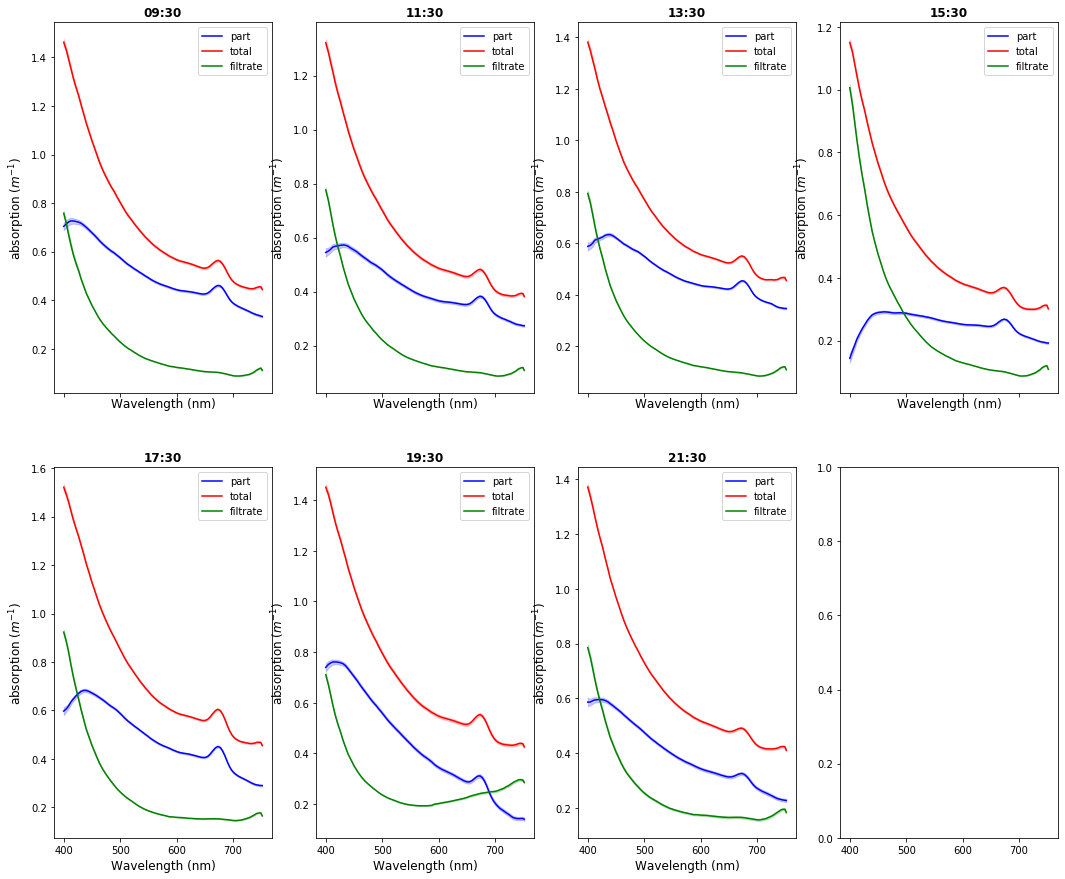

In [16]:
################## A SIDE

times = ['09:30','11:30','13:30','15:30','17:30','19:30','21:30']
times_ = ['0930','1130','1330','1530','1730','1930','2130']
fig, axs = plt.subplots(2,4, sharey=False, sharex=True,figsize=(18,15))

k=0
while k<=6:
    for i in range(2):
        for j in range(4):
            p_med = globals()['a_part_'+times_[k]+'_med']
            p_std = globals()['a_part_'+times_[k]+'_std']
            t_med = globals()['a_tot_'+times_[k]+'_med']
            t_std = globals()['a_tot_'+times_[k]+'_std']
            f_med = globals()['a_filt_'+times_[k]+'_med']
            f_std = globals()['a_filt_'+times_[k]+'_std']
            
            axs[i][j].plot(a_wav,p_med,color='blue',label='part')
            axs[i][j].fill_between(a_wav, p_med+p_std, p_med-p_std, color='blue',alpha=0.2)
            
            axs[i][j].plot(a_wav,t_med,color='red',label='total')
            axs[i][j].fill_between(a_wav, t_med+t_std, t_med-t_std, color='red',alpha=0.2)
            
            axs[i][j].plot(a_wav,f_med,color='green',label='filtrate')
            axs[i][j].fill_between(a_wav, f_med+f_std, f_med-f_std, color='green',alpha=0.2)
            
            axs[i][j].set_title(times[k],fontweight='bold')
            axs[i][j].legend()
            
            axs[i][j].set_xlabel('Wavelength (nm)',fontsize=12)
            axs[i][j].set_ylabel('absorption ($m^{-1}$)',fontsize=12)
            
            k+=1
plt.show()

IndexError: list index out of range

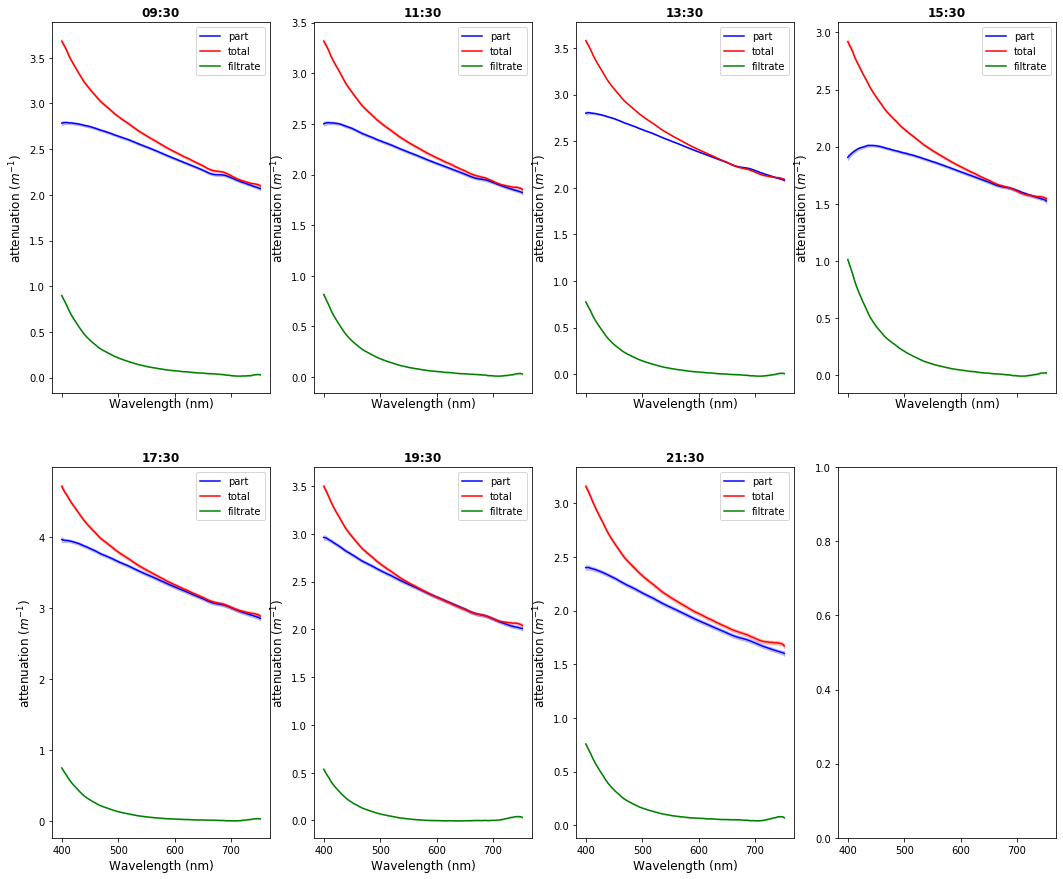

In [17]:
####################### C SIDE


times = ['09:30','11:30','13:30','15:30','17:30','19:30','21:30']
times_ = ['0930','1130','1330','1530','1730','1930','2130']
fig, axs = plt.subplots(2,4, sharey=False, sharex=True,figsize=(18,15))

k=0
while k<=6:
    for i in range(2):
        for j in range(4):
            p_med = globals()['c_part_'+times_[k]+'_med']
            p_std = globals()['c_part_'+times_[k]+'_std']
            t_med = globals()['c_tot_'+times_[k]+'_med']
            t_std = globals()['c_tot_'+times_[k]+'_std']
            f_med = globals()['c_filt_'+times_[k]+'_med']
            f_std = globals()['c_filt_'+times_[k]+'_std']
            
            axs[i][j].plot(a_wav,p_med,color='blue',label='part')
            axs[i][j].fill_between(a_wav, p_med+p_std, p_med-p_std, color='blue',alpha=0.2)
            
            axs[i][j].plot(a_wav,t_med,color='red',label='total')
            axs[i][j].fill_between(a_wav, t_med+t_std, t_med-t_std, color='red',alpha=0.2)
            
            axs[i][j].plot(a_wav,f_med,color='green',label='filtrate')
            axs[i][j].fill_between(a_wav, f_med+f_std, f_med-f_std, color='green',alpha=0.2)
            
            axs[i][j].set_title(times[k],fontweight='bold')
            axs[i][j].legend()
            
            axs[i][j].set_xlabel('Wavelength (nm)',fontsize=12)
            axs[i][j].set_ylabel('attenuation ($m^{-1}$)',fontsize=12)
            
            k+=1
plt.show()

 #### Inspect Temperature and Scatter corrected particulate data

In [18]:
# Temperature and Scatter correct the particulate data
[a_part_0930_corr,c_part_0930_corr] = ResidualTemperatureAndScatteringCorrection(a_part_0930_med[None,:], c_part_0930_med[None,:], a_wav)
[a_part_1130_corr,c_part_1130_corr] = ResidualTemperatureAndScatteringCorrection(a_part_1130_med[None,:], c_part_1130_med[None,:], a_wav)
[a_part_1330_corr,c_part_1330_corr] = ResidualTemperatureAndScatteringCorrection(a_part_1330_med[None,:], c_part_1330_med[None,:], a_wav)
[a_part_1530_corr,c_part_1530_corr] = ResidualTemperatureAndScatteringCorrection(a_part_1530_med[None,:], c_part_1530_med[None,:], a_wav)
[a_part_1730_corr,c_part_1730_corr] = ResidualTemperatureAndScatteringCorrection(a_part_1730_med[None,:], c_part_1730_med[None,:], a_wav)
[a_part_1930_corr,c_part_1930_corr] = ResidualTemperatureAndScatteringCorrection(a_part_1930_med[None,:], c_part_1930_med[None,:], a_wav)
[a_part_2130_corr,c_part_2130_corr] = ResidualTemperatureAndScatteringCorrection(a_part_2130_med[None,:], c_part_2130_med[None,:], a_wav)

IndexError: list index out of range

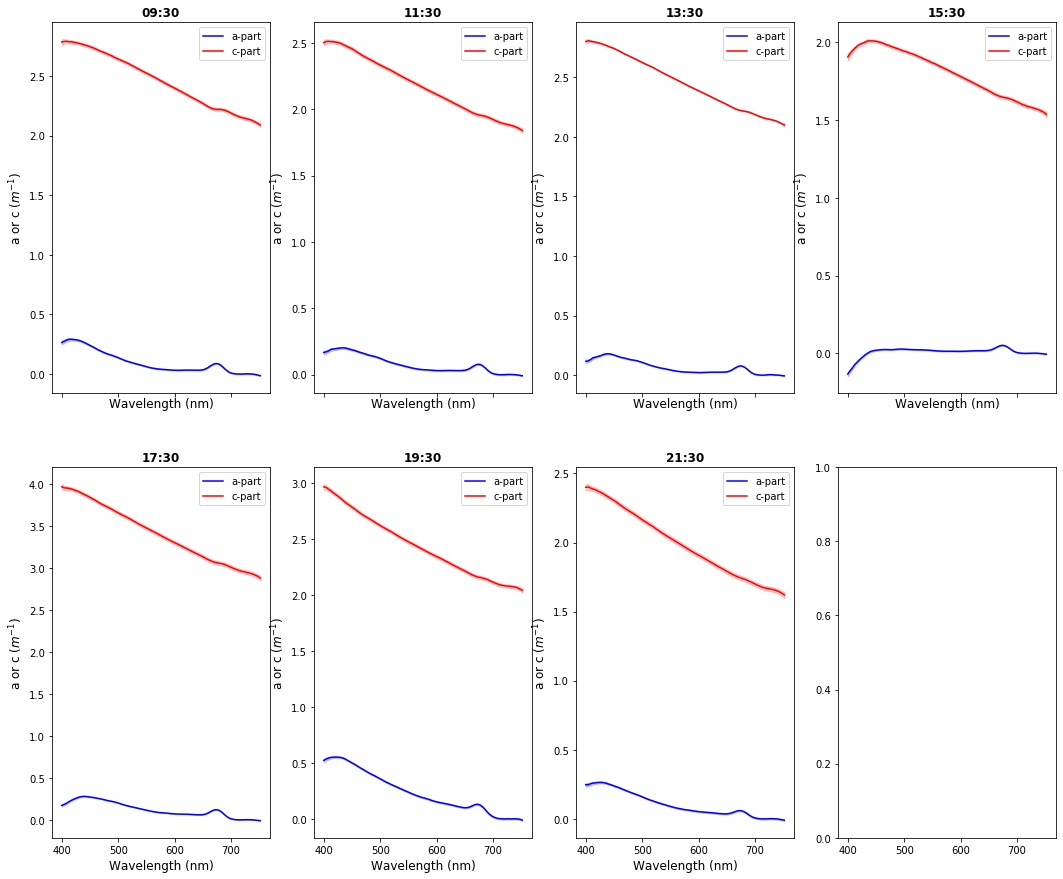

In [19]:
times = ['09:30','11:30','13:30','15:30','17:30','19:30','21:30']
times_ = ['0930','1130','1330','1530','1730','1930','2130']
fig, axs = plt.subplots(2,4, sharey=False, sharex=True,figsize=(18,15))

k=0
while k<=6:
    for i in range(2):
        for j in range(4):
            ap_med = globals()['a_part_'+times_[k]+'_corr'][0]
            ap_std = globals()['a_part_'+times_[k]+'_std']
            
            cp_med = globals()['c_part_'+times_[k]+'_corr'][0]
            cp_std = globals()['c_part_'+times_[k]+'_std']

            
            axs[i][j].plot(a_wav,ap_med,color='blue',label='a-part')
            axs[i][j].fill_between(a_wav, ap_med+ap_std, ap_med-ap_std, color='blue',alpha=0.2)
            
            axs[i][j].plot(a_wav,cp_med,color='red',label='c-part')
            axs[i][j].fill_between(a_wav, cp_med+cp_std, cp_med-cp_std, color='red',alpha=0.2)
            
            axs[i][j].set_title(times[k],fontweight='bold')
            axs[i][j].legend()
            
            axs[i][j].set_xlabel('Wavelength (nm)',fontsize=12)
            axs[i][j].set_ylabel('a or c ($m^{-1}$)',fontsize=12)
            
            k+=1
plt.show()

#### Try fudging the 15:30 and 19:30 particulate timepoints by using different timepoints' filtrates

In [20]:
# Fudged 15:30 timepoint with combined filtrates
a_part_1530_med = a_tot_1530_med - np.mean((a_filt_1330_med,a_filt_1730_med),axis=0)
a_part_1530_std = np.sqrt(a_tot_1530_std**2 + a_filt_1330_std**2 + a_filt_1730_std**2)

c_part_1530_med = c_tot_1530_med - np.mean((c_filt_1330_med,c_filt_1730_med),axis=0)
c_part_1530_std = np.sqrt(c_tot_1530_std**2 + c_filt_1330_std**2 + c_filt_1730_std**2)


In [21]:
# Try fudging the  19:30 timepoint with combined filtrates
a_part_1930_med = a_tot_1930_med - np.mean((a_filt_1730_med,a_filt_2130_med),axis=0)
a_part_1930_std = np.sqrt(a_tot_1930_std**2 + a_filt_1730_std**2 + a_filt_2130_std**2)

c_part_1930_med = c_tot_1930_med - np.mean((c_filt_1730_med,c_filt_2130_med),axis=0)
c_part_1930_std = np.sqrt(c_tot_1930_std**2 + c_filt_1730_std**2 + c_filt_2130_std**2)


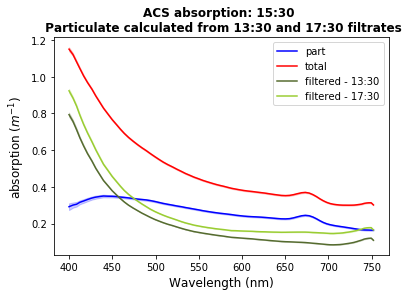

In [22]:
plt.plot(a_wav,a_part_1530_med,color='blue',label='part')
plt.fill_between(a_wav, a_part_1530_med+a_part_1530_std, a_part_1530_med-a_part_1530_std,color='blue',alpha=0.2)
plt.plot(a_wav, a_tot_1530_med,color='red',label='total')
plt.fill_between(a_wav, a_tot_1530_med+a_tot_1530_std, a_tot_1530_med-a_tot_1530_std,color='red',alpha=0.2)
plt.plot(a_wav, a_filt_1330_med,color='darkolivegreen',label='filtered - 13:30')
plt.fill_between(a_wav, a_filt_1330_med+a_filt_1330_std, a_filt_1330_med-a_filt_1330_std,color='darkolivegreen',alpha=0.2)
plt.plot(a_wav, a_filt_1730_med,color='yellowgreen',label='filtered - 17:30')
plt.fill_between(a_wav, a_filt_1730_med+a_filt_1730_std, a_filt_1730_med-a_filt_1730_std,color='yellowgreen',alpha=0.2)


plt.xlabel('Wavelength (nm)',fontsize=12)
plt.ylabel('absorption ($m^{-1}$)',fontsize=12)
plt.title('ACS absorption: 15:30 \n Particulate calculated from 13:30 and 17:30 filtrates',fontweight='bold')
plt.legend()

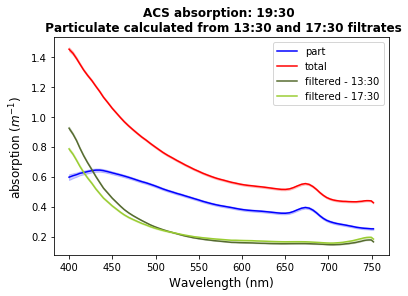

In [23]:
plt.plot(a_wav,a_part_1930_med,color='blue',label='part')
plt.fill_between(a_wav, a_part_1930_med+a_part_1930_std, a_part_1930_med-a_part_1930_std,color='blue',alpha=0.2)
plt.plot(a_wav, a_tot_1930_med,color='red',label='total')
plt.fill_between(a_wav, a_tot_1930_med+a_tot_1930_std, a_tot_1930_med-a_tot_1930_std,color='red',alpha=0.2)
plt.plot(a_wav, a_filt_1730_med,color='darkolivegreen',label='filtered - 13:30')
plt.fill_between(a_wav, a_filt_1730_med+a_filt_1730_std, a_filt_1730_med-a_filt_1730_std,color='darkolivegreen',alpha=0.2)
plt.plot(a_wav, a_filt_2130_med,color='yellowgreen',label='filtered - 17:30')
plt.fill_between(a_wav, a_filt_2130_med+a_filt_2130_std, a_filt_2130_med-a_filt_2130_std,color='yellowgreen',alpha=0.2)


plt.xlabel('Wavelength (nm)',fontsize=12)
plt.ylabel('absorption ($m^{-1}$)',fontsize=12)
plt.title('ACS absorption: 19:30 \n Particulate calculated from 13:30 and 17:30 filtrates',fontweight='bold')
plt.legend()

 #### Inspect Temperature and Scatter corrected particulate data

In [24]:
# Temperature and Scatter correct the particulate data
[a_part_0930_corr,c_part_0930_corr] = ResidualTemperatureAndScatteringCorrection(a_part_0930_med[None,:], c_part_0930_med[None,:], a_wav)
[a_part_1130_corr,c_part_1130_corr] = ResidualTemperatureAndScatteringCorrection(a_part_1130_med[None,:], c_part_1130_med[None,:], a_wav)
[a_part_1330_corr,c_part_1330_corr] = ResidualTemperatureAndScatteringCorrection(a_part_1330_med[None,:], c_part_1330_med[None,:], a_wav)
[a_part_1530_corr,c_part_1530_corr] = ResidualTemperatureAndScatteringCorrection(a_part_1530_med[None,:], c_part_1530_med[None,:], a_wav)
[a_part_1730_corr,c_part_1730_corr] = ResidualTemperatureAndScatteringCorrection(a_part_1730_med[None,:], c_part_1730_med[None,:], a_wav)
[a_part_1930_corr,c_part_1930_corr] = ResidualTemperatureAndScatteringCorrection(a_part_1930_med[None,:], c_part_1930_med[None,:], a_wav)
[a_part_2130_corr,c_part_2130_corr] = ResidualTemperatureAndScatteringCorrection(a_part_2130_med[None,:], c_part_2130_med[None,:], a_wav)

IndexError: list index out of range

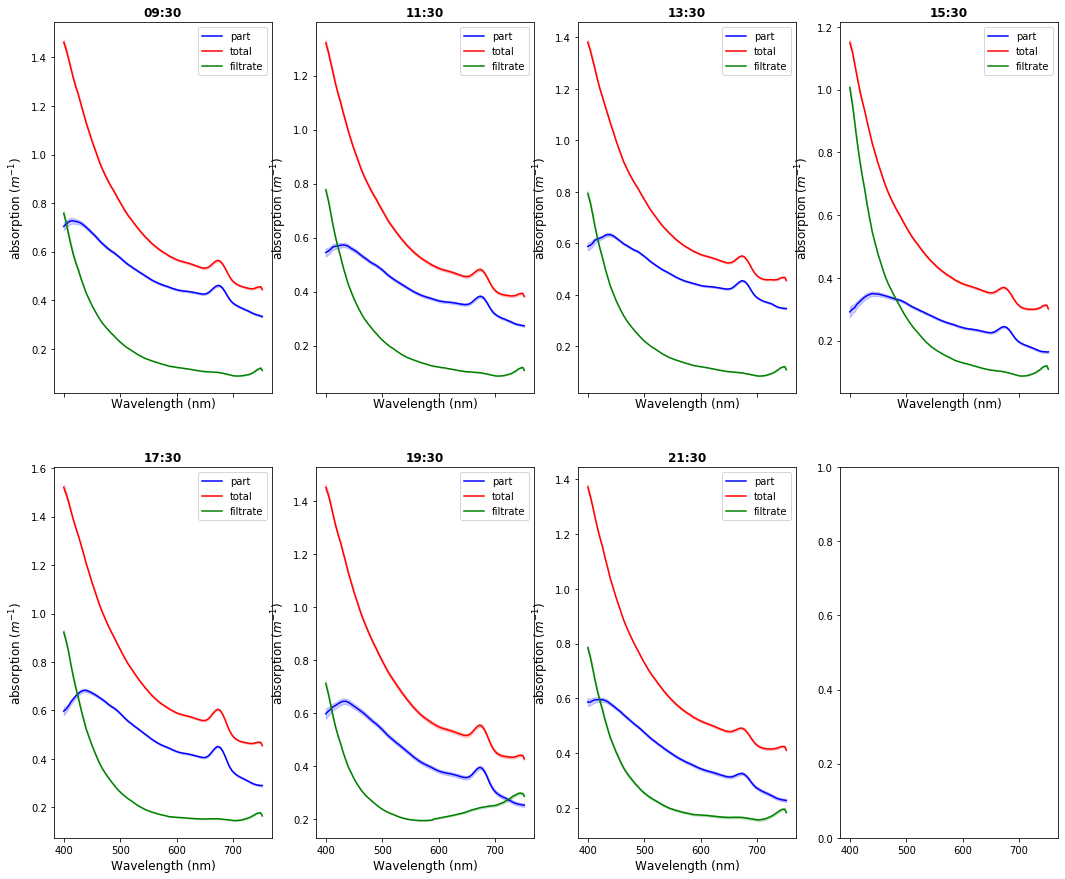

In [25]:
times = ['09:30','11:30','13:30','15:30','17:30','19:30','21:30']
times_ = ['0930','1130','1330','1530','1730','1930','2130']
fig, axs = plt.subplots(2,4, sharey=False, sharex=True,figsize=(18,15))

k=0
while k<=6:
    for i in range(2):
        for j in range(4):
            p_med = globals()['a_part_'+times_[k]+'_med']
            p_std = globals()['a_part_'+times_[k]+'_std']
            t_med = globals()['a_tot_'+times_[k]+'_med']
            t_std = globals()['a_tot_'+times_[k]+'_std']
            f_med = globals()['a_filt_'+times_[k]+'_med']
            f_std = globals()['a_filt_'+times_[k]+'_std']
            
            axs[i][j].plot(a_wav,p_med,color='blue',label='part')
            axs[i][j].fill_between(a_wav, p_med+p_std, p_med-p_std, color='blue',alpha=0.2)
            
            axs[i][j].plot(a_wav,t_med,color='red',label='total')
            axs[i][j].fill_between(a_wav, t_med+t_std, t_med-t_std, color='red',alpha=0.2)
            
            axs[i][j].plot(a_wav,f_med,color='green',label='filtrate')
            axs[i][j].fill_between(a_wav, f_med+f_std, f_med-f_std, color='green',alpha=0.2)
            
            axs[i][j].set_title(times[k],fontweight='bold')
            axs[i][j].legend()
            
            axs[i][j].set_xlabel('Wavelength (nm)',fontsize=12)
            axs[i][j].set_ylabel('absorption ($m^{-1}$)',fontsize=12)
            
            k+=1
plt.show()

IndexError: list index out of range

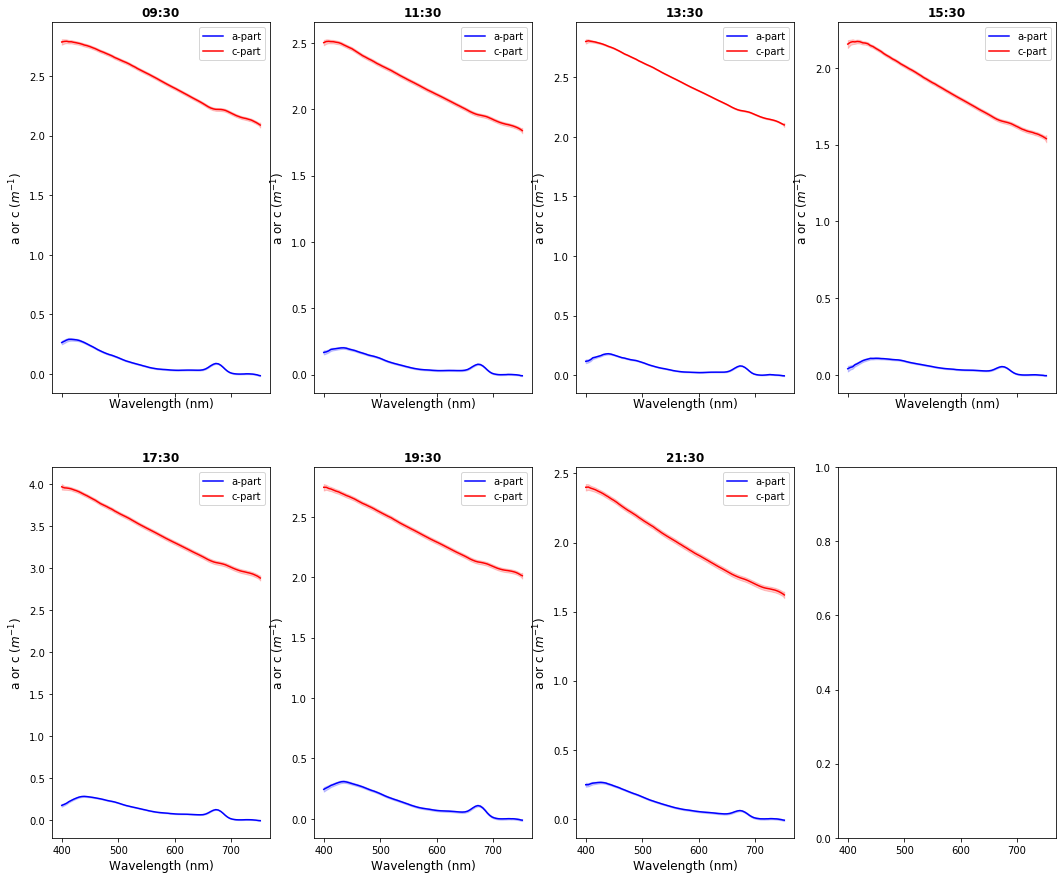

In [26]:
times = ['09:30','11:30','13:30','15:30','17:30','19:30','21:30']
times_ = ['0930','1130','1330','1530','1730','1930','2130']
fig, axs = plt.subplots(2,4, sharey=False, sharex=True,figsize=(18,15))

k=0
while k<=6:
    for i in range(2):
        for j in range(4):
            ap_med = globals()['a_part_'+times_[k]+'_corr'][0]
            ap_std = globals()['a_part_'+times_[k]+'_std']
            
            cp_med = globals()['c_part_'+times_[k]+'_corr'][0]
            cp_std = globals()['c_part_'+times_[k]+'_std']

            
            axs[i][j].plot(a_wav,ap_med,color='blue',label='a-part')
            axs[i][j].fill_between(a_wav, ap_med+ap_std, ap_med-ap_std, color='blue',alpha=0.2)
            
            axs[i][j].plot(a_wav,cp_med,color='red',label='c-part')
            axs[i][j].fill_between(a_wav, cp_med+cp_std, cp_med-cp_std, color='red',alpha=0.2)
            
            axs[i][j].set_title(times[k],fontweight='bold')
            axs[i][j].legend()
            
            axs[i][j].set_xlabel('Wavelength (nm)',fontsize=12)
            axs[i][j].set_ylabel('a or c ($m^{-1}$)',fontsize=12)
            
            k+=1
plt.show()

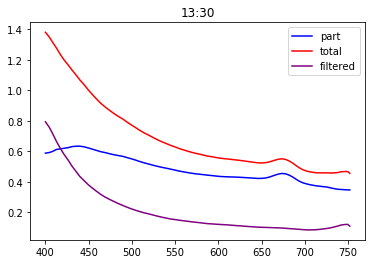

In [27]:
plt.plot(a_wav,a_part_1330_med,color='blue',label='part')
plt.plot(a_wav,a_tot_1330_med,color='red',label='total')
plt.plot(a_wav,a_filt_1330_med,color='purple',label='filtered')
plt.title('13:30')
plt.legend()


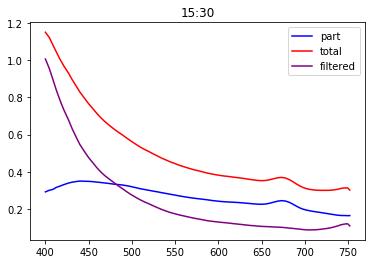

In [28]:
plt.plot(a_wav,a_part_1530_med,color='blue',label='part')
plt.plot(a_wav,a_tot_1530_med,color='red',label='total')
plt.plot(a_wav,a_filt_1530_med,color='purple',label='filtered')
plt.title('15:30')
plt.legend()


## Read in hyperBB data (processed in MatLab)

In [88]:
bbp = pd.read_csv('~/Documents/OO2021/bb-b/d_processed/HBB/hbb_bp_total.csv')
bbp_std = pd.read_csv('~/Documents/OO2021/bb-b/d_processed/HBB/hbb_bp_total_std.csv')

In [140]:
bbp_x = bbp[~bbp['Wavelength'].isin([430,440,660,670,680])] #filter out wavelengths with strong abs or fluorescence signals
bbp_x_std = bbp_std[~bbp_std['Wavelength'].isin([430,440,660,670,680])] #filter out wavelengths with strong abs or fluorescence signals

IndexError: list index out of range

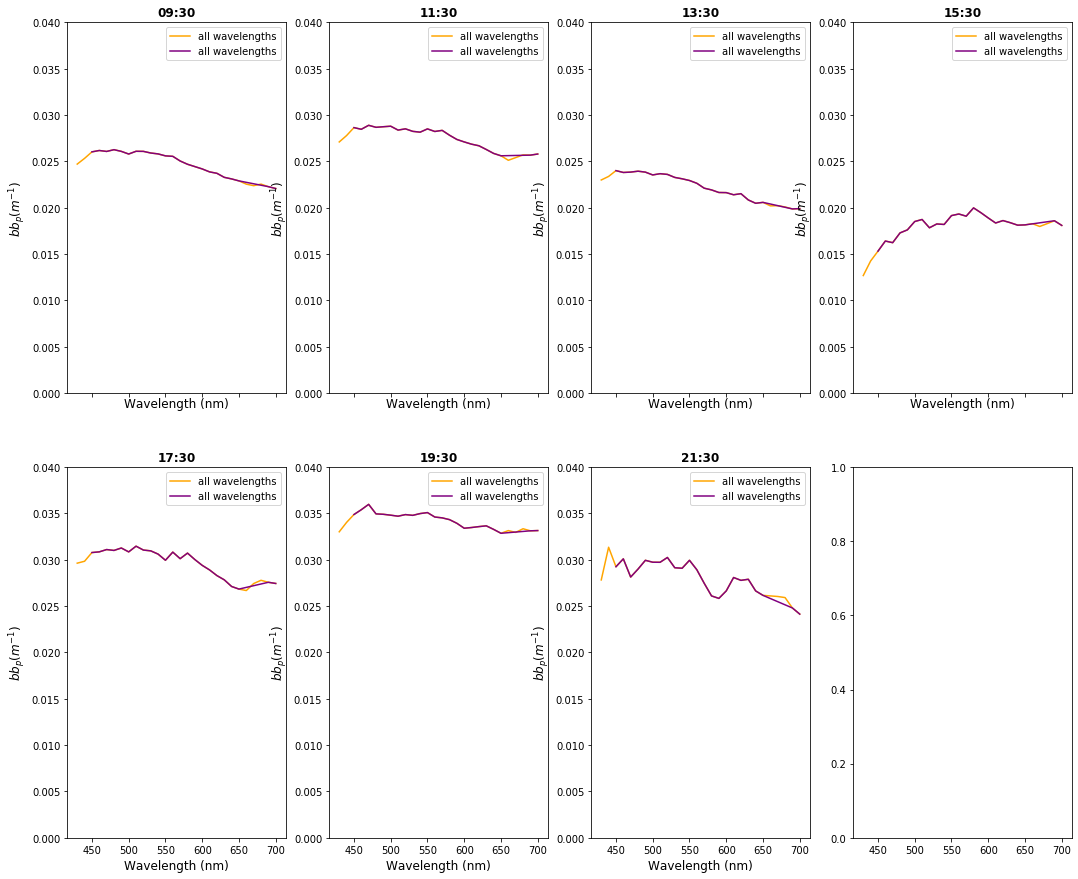

In [91]:
times = ['09:30','11:30','13:30','15:30','17:30','19:30','21:30']
times_ = ['0930','1130','1330','1530','1730','1930','2130']
fig, axs = plt.subplots(2,4, sharey=False, sharex=True,figsize=(18,15))

k=0
while k<=6:
    for i in range(2):
        for j in range(4):

            axs[i][j].plot(bbp['Wavelength'],bbp[[times_[k]]],color='orange',label='all wavelengths')
            axs[i][j].plot(bbp_x['Wavelength'],bbp_x[[times_[k]]],color='purple',label='all wavelengths')
    
            axs[i][j].set_title(times[k],fontweight='bold')
            axs[i][j].legend()
                
            axs[i][j].set_xlabel('Wavelength (nm)',fontsize=12)
            axs[i][j].set_ylabel('$bb_p (m^{-1})$',fontsize=12)
            axs[i][j].set_ylim(0,0.04)
                      
            k+=1
plt.show()

### Fit power laws to bb spectral slopes fitting

In [92]:
def power_law(x, a, b):
    return a*np.power(x, b)

In [93]:
###################### FITS FOR COMPLETE DATA
bb_pl_pars = {}
bb_pl_cov = {}
bb_pl_stds = {}
bb_pl_res = {} # Residuals

for i in range(7):
    
    bb_pl_pars[bbp.columns[i]], bb_pl_cov[bbp.columns[i]] = curve_fit(f=power_law, xdata=bbp['Wavelength'], ydata=bbp[bbp.columns[i]], p0=[0,0], bounds=(-np.inf, np.inf))
    
    # Get the standard deviations of the parameters (square roots of the # diagonal of the covariance)
    bb_pl_stds[bbp.columns[i]] = np.sqrt(np.diag(bb_pl_cov[bbp.columns[i]]))
    
    # Calculate the residuals
    bb_pl_res[bbp.columns[i]] = bbp[bbp.columns[i]] - power_law(bbp['Wavelength'], *bb_pl_pars[bbp.columns[i]])


In [95]:
###################### FITS FOR TRIMMED DATA (REMOVED WAVELENGTHS)
bbx_pl_pars = {}
bbx_pl_cov = {}
bbx_pl_stds = {}
bbx_pl_res = {} # Residuals

for i in range(8):
    
    bbx_pl_pars[bbp_x.columns[i]], bbx_pl_cov[bbp.columns[i]] = curve_fit(f=power_law, xdata=bbp_x['Wavelength'], ydata=bbp_x[bbp_x.columns[i]], p0=[0,0], bounds=(-np.inf, np.inf))
    
    # Get the standard deviations of the parameters (square roots of the # diagonal of the covariance)
    bbx_pl_stds[bbp_x.columns[i]] = np.sqrt(np.diag(bbx_pl_cov[bbp_x.columns[i]]))
    
    # Calculate the residuals
    bbx_pl_res[bbp_x.columns[i]] = bbp_x[bbp_x.columns[i]] - power_law(bbp_x['Wavelength'], *bbx_pl_pars[bbp_x.columns[i]])


IndexError: list index out of range

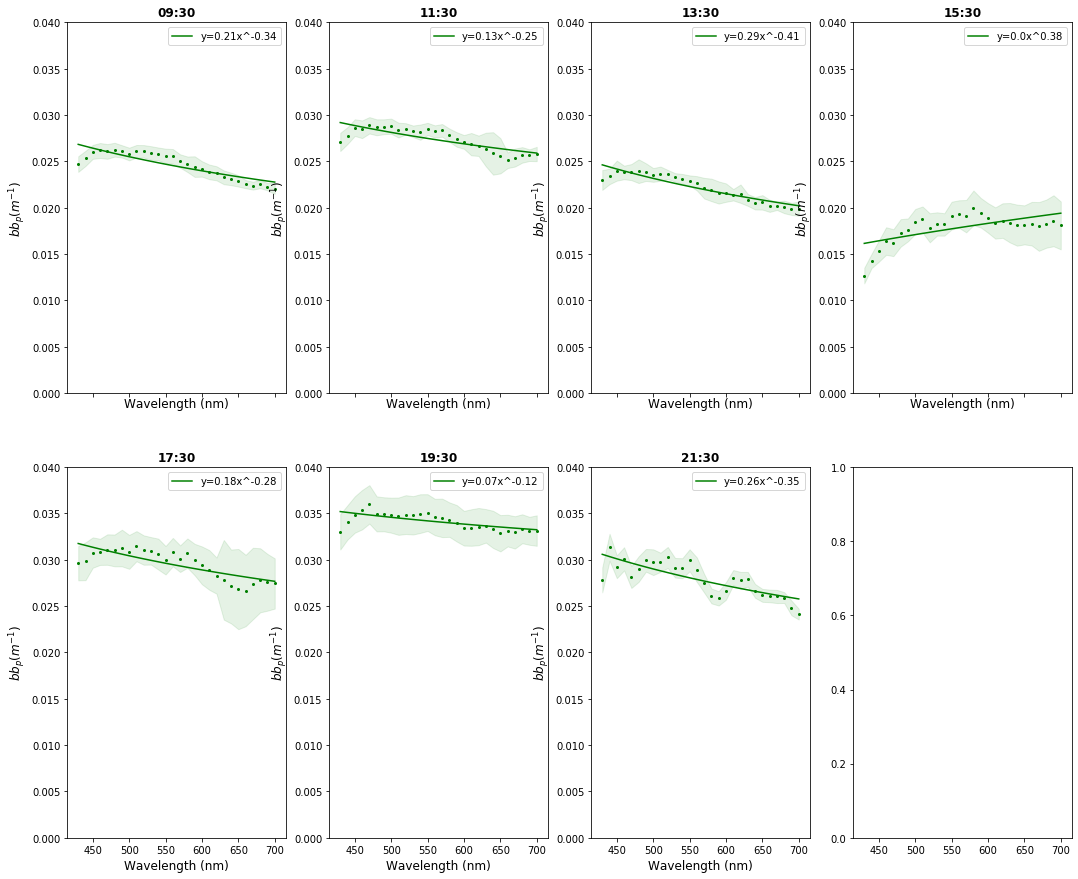

In [146]:
###################### Plots of complete data
fig, axs = plt.subplots(2,4, sharey=False, sharex=True,figsize=(18,15))

k=0
while k<=6:
    for i in range(2):
        for j in range(4):
            axs[i][j].scatter(bbp['Wavelength'],bbp[times_[k]],color='green',s=4)
            
            axs[i][j].fill_between(bbp['Wavelength'],
                                   bbp[times_[k]]+bbp_std[times_[k]],
                                   bbp[times_[k]]-bbp_std[times_[k]],
                                  color='green',alpha=0.1)
            
            axs[i][j].plot(bbp['Wavelength'],
                               power_law(bbp['Wavelength'], *bb_pl_pars[times_[k]]),
                               color='green',
                               label='y={}x^{}'.format(round(bb_pl_pars[times_[k]][0],2),round(bb_pl_pars[times_[k]][1],2)))
    
            axs[i][j].set_title(times[k],fontweight='bold')
            axs[i][j].legend()
                
            axs[i][j].set_xlabel('Wavelength (nm)',fontsize=12)
            axs[i][j].set_ylabel('$bb_p (m^{-1})$',fontsize=12)
            axs[i][j].set_ylim(0,0.04)
            
                      
            k+=1
plt.show()
figure.suptitle("$bb_p$ power law fits")

IndexError: list index out of range

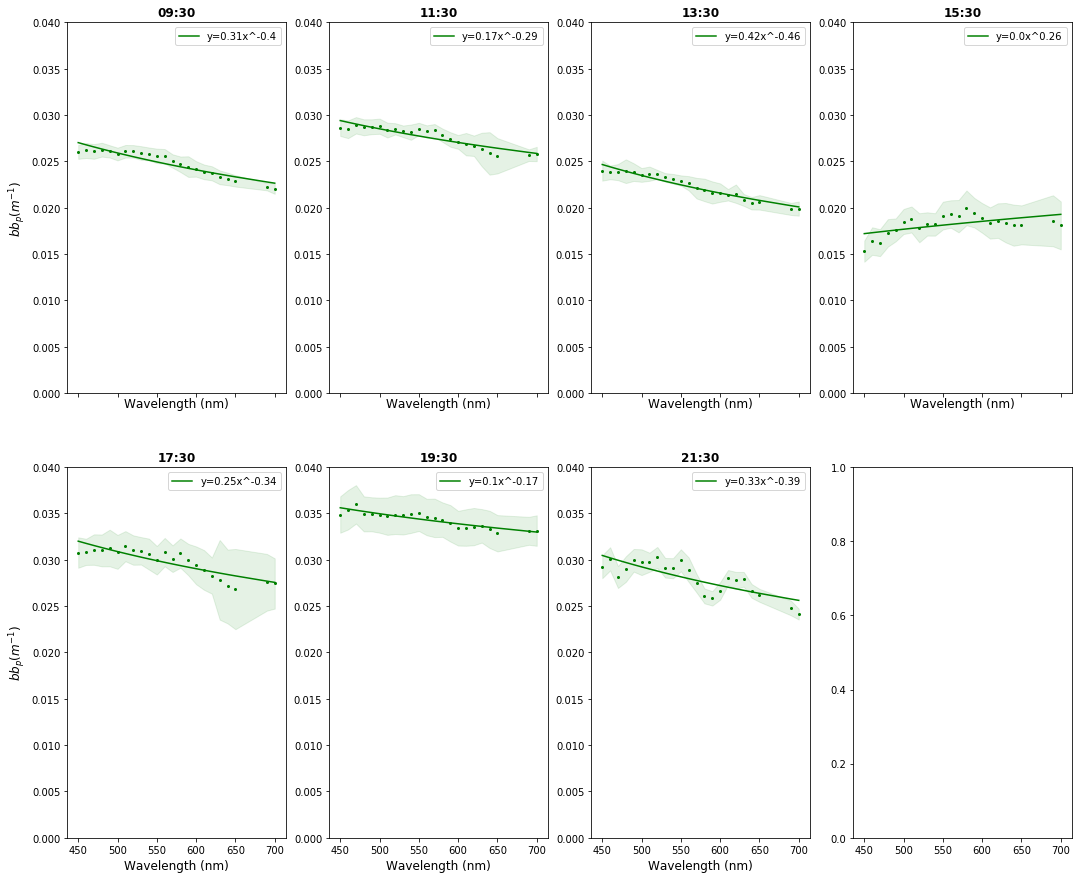

In [155]:
###################### Plots of trimmed data
fig, axs = plt.subplots(2,4, sharey=False, sharex=True,figsize=(18,15))

k=0
while k<=6:
    for i in range(2):
        for j in range(4):
            axs[i][j].scatter(bbp_x['Wavelength'],bbp_x[times_[k]],color='green',s=4)
            
            axs[i][j].fill_between(bbp_x['Wavelength'],
                                   bbp_x[times_[k]]+bbp_x_std[times_[k]],
                                   bbp_x[times_[k]]-bbp_x_std[times_[k]],
                                  color='green',alpha=0.1)
            
            axs[i][j].plot(bbp_x['Wavelength'],
                               power_law(bbp_x['Wavelength'], *bbx_pl_pars[times_[k]]),
                               color='green',
                               label='y={}x^{}'.format(round(bbx_pl_pars[times_[k]][0],2),round(bbx_pl_pars[times_[k]][1],2)))
    
            axs[i][j].set_title(times[k],fontweight='bold')
            axs[i][j].legend()
            
            
            axs[i][j].set_xlabel('Wavelength (nm)',fontsize=12)
            if k in [0,4]:
                axs[i][j].set_ylabel('$bb_p (m^{-1})$',fontsize=12)
            axs[i][j].set_ylim(0,0.04)
            
                      
            k+=1

plt.suptitle("$bb_p$ power law fits \n Removed 430,440,660,670,680")
fig.tight_layout()
plt.show()

IndexError: list index out of range

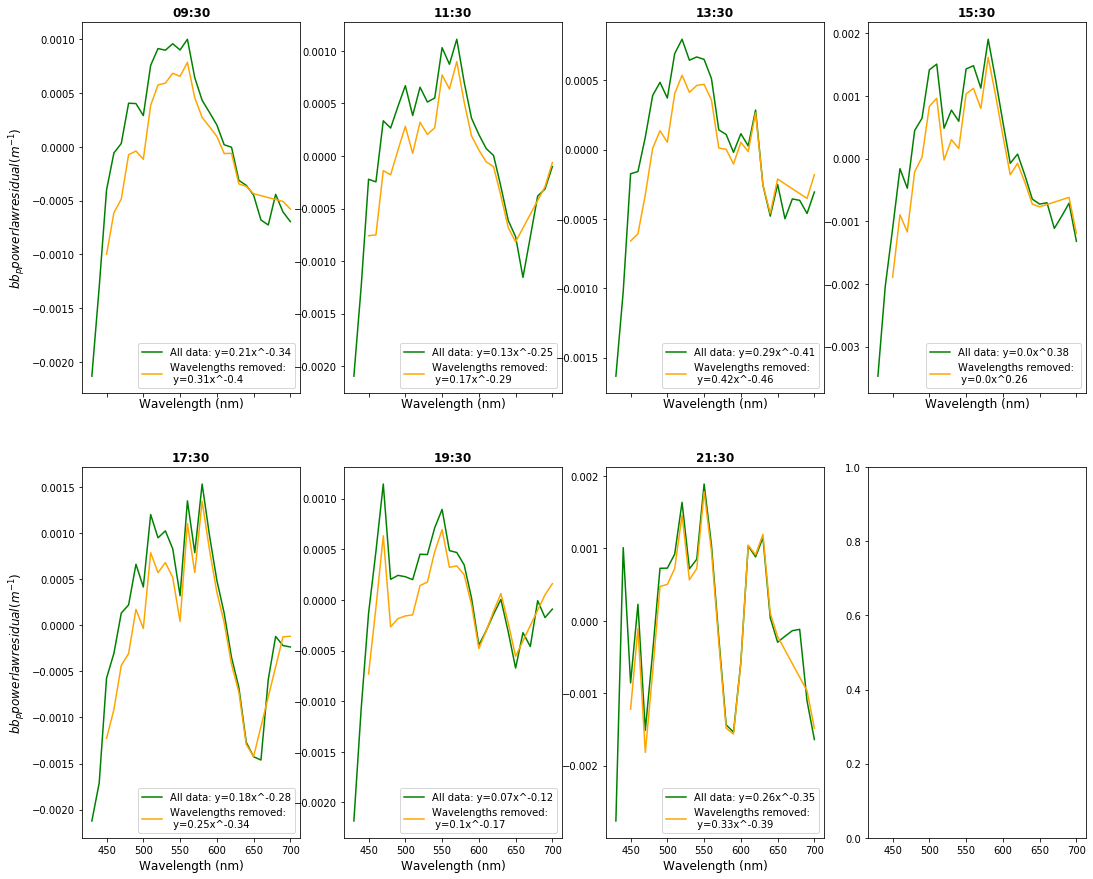

In [170]:
###################### Plots of residuals
fig, axs = plt.subplots(2,4, sharey=False, sharex=True,figsize=(18,15))

k=0
while k<=6:
    for i in range(2):
        for j in range(4):
            
            axs[i][j].plot(bbp['Wavelength'],
                               bb_pl_res[times_[k]],
                               color='green',
                               label='All data: y={}x^{}'.format(round(bb_pl_pars[times_[k]][0],2),round(bb_pl_pars[times_[k]][1],2)))
            
            axs[i][j].plot(bbp_x['Wavelength'],
                               bbx_pl_res[times_[k]],
                               color='orange',
                               label='Wavelengths removed: \n y={}x^{}'.format(round(bbx_pl_pars[times_[k]][0],2),round(bbx_pl_pars[times_[k]][1],2)))
    
            axs[i][j].set_title(times[k],fontweight='bold')
            axs[i][j].legend()
            
            axs[i][j].set_xlabel('Wavelength (nm)',fontsize=12)
            if k in [0,4]:
                axs[i][j].set_ylabel('$bb_p power law residual (m^{-1})$',fontsize=12)
            
                      
            k+=1

plt.suptitle("$bb_p$ power law fits")
fig.tight_layout()
plt.show()

IndexError: list index out of range

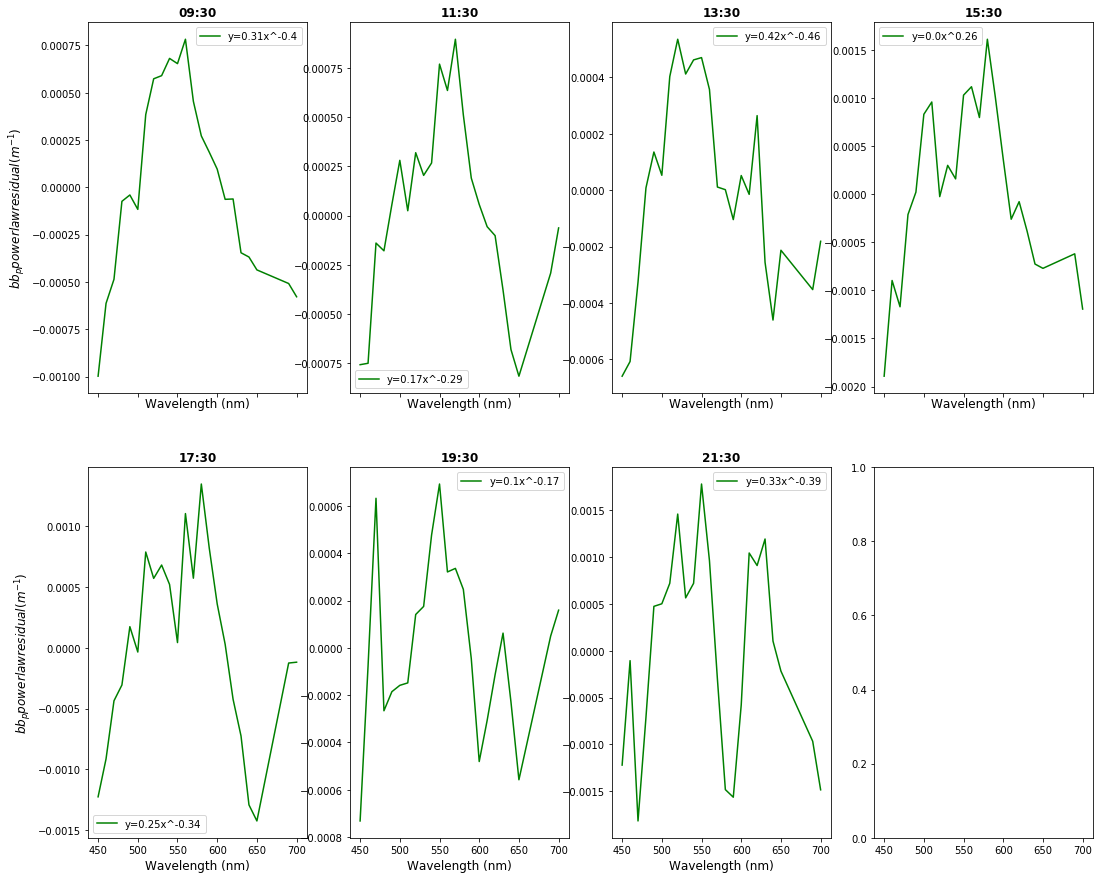

In [156]:
###################### Plots of residuals
fig, axs = plt.subplots(2,4, sharey=False, sharex=True,figsize=(18,15))

k=0
while k<=6:
    for i in range(2):
        for j in range(4):
            
            axs[i][j].plot(bbp_x['Wavelength'],
                               bbx_pl_res[times_[k]],
                               color='green',
                               label='y={}x^{}'.format(round(bbx_pl_pars[times_[k]][0],2),round(bbx_pl_pars[times_[k]][1],2)))
    
            axs[i][j].set_title(times[k],fontweight='bold')
            axs[i][j].legend()
            
            axs[i][j].set_xlabel('Wavelength (nm)',fontsize=12)
            if k in [0,4]:
                axs[i][j].set_ylabel('$bb_p power law residual (m^{-1})$',fontsize=12)
            
                      
            k+=1

plt.suptitle("$bb_p$ power law fits \n Removed 430,440,660,670,680")
fig.tight_layout()
plt.show()

### Particulate beam attenuation spectral slope
##### Use total fraction to account for issues in the filtrate

In [98]:
# Temperature and Scatter correct the total water data
[a_tot_0930_corr,c_tot_0930_corr] = ResidualTemperatureAndScatteringCorrection(a_tot_0930_med[None,:], c_tot_0930_med[None,:], a_wav)
[a_tot_1130_corr,c_tot_1130_corr] = ResidualTemperatureAndScatteringCorrection(a_tot_1130_med[None,:], c_tot_1130_med[None,:], a_wav)
[a_tot_1330_corr,c_tot_1330_corr] = ResidualTemperatureAndScatteringCorrection(a_tot_1330_med[None,:], c_tot_1330_med[None,:], a_wav)
[a_tot_1530_corr,c_tot_1530_corr] = ResidualTemperatureAndScatteringCorrection(a_tot_1530_med[None,:], c_tot_1530_med[None,:], a_wav)
[a_tot_1730_corr,c_tot_1730_corr] = ResidualTemperatureAndScatteringCorrection(a_tot_1730_med[None,:], c_tot_1730_med[None,:], a_wav)
[a_tot_1930_corr,c_tot_1930_corr] = ResidualTemperatureAndScatteringCorrection(a_tot_1930_med[None,:], c_tot_1930_med[None,:], a_wav)
[a_tot_2130_corr,c_tot_2130_corr] = ResidualTemperatureAndScatteringCorrection(a_tot_2130_med[None,:], c_tot_2130_med[None,:], a_wav)

In [99]:
###################### Use C-tot, corrected for temp
cp_pl_pars = {}
cp_pl_cov = {}
cp_pl_stds = {}
cp_pl_res = {} # Residuals



for i in range(7):
    
    cp_pl_pars[times_[i]], cp_pl_cov[times_[i]] = curve_fit(f=power_law, xdata=a_wav, ydata=globals()['c_tot_'+times_[i]+'_corr'][0], p0=[0,0], bounds=(-np.inf, np.inf))
    
    # Get the standard deviations of the parameters (square roots of the # diagonal of the covariance)
    cp_pl_stds[times_[i]] = np.sqrt(np.diag(cp_pl_cov[times_[i]]))
    
    # Calculate the residuals
    cp_pl_res[times_[i]] = globals()['c_tot_'+times_[i]+'_corr'][0] - power_law(a_wav, *cp_pl_pars[times_[i]])


IndexError: list index out of range

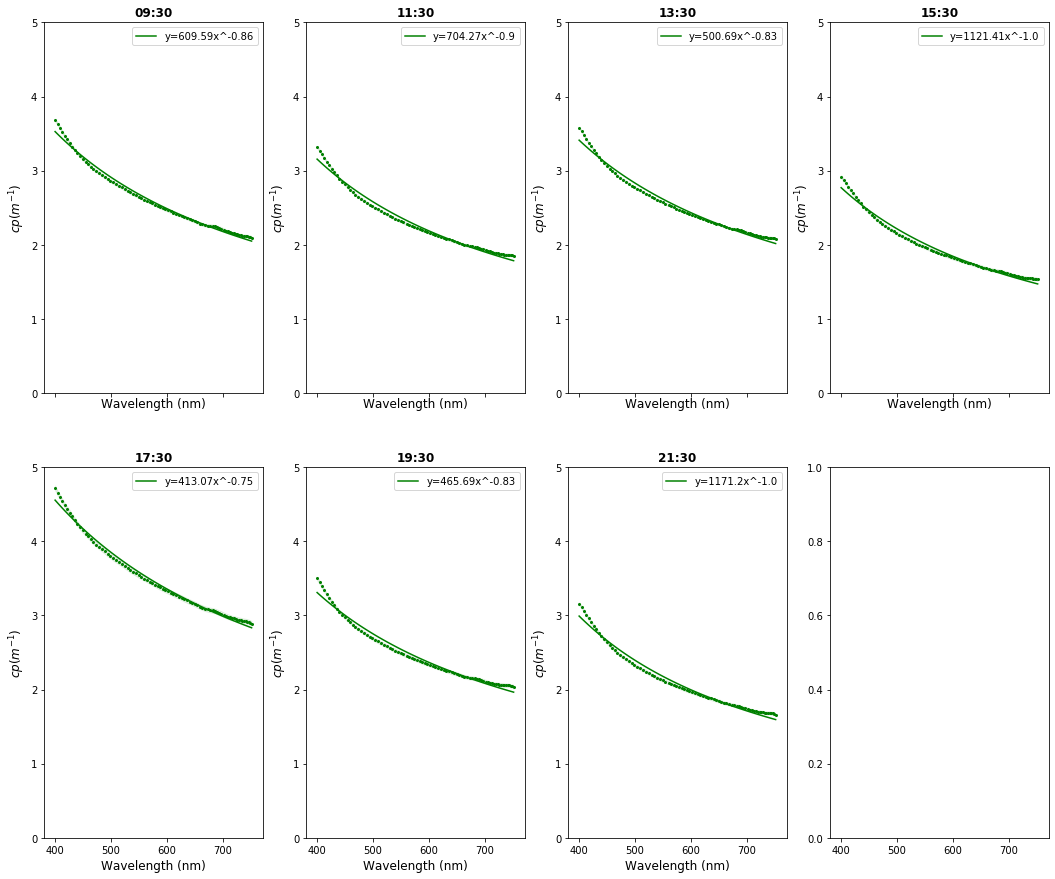

In [139]:
###################### Plot atennuation power laws
fig, axs = plt.subplots(2,4, sharey=False, sharex=True,figsize=(18,15))

k=0
while k<=6:
    for i in range(2):
        for j in range(4):
            axs[i][j].scatter(a_wav,globals()['c_tot_'+times_[k]+'_corr'][0],
                                  color='green',s=4)
            
            axs[i][j].fill_between(a_wav,
                                   globals()['c_tot_'+times_[k]+'_corr'][0]+globals()['c_tot_'+times_[k]+'_std'][0],
                                   globals()['c_tot_'+times_[k]+'_corr'][0]-globals()['c_tot_'+times_[k]+'_std'][0],
                                  color='green',alpha=0.1)
            axs[i][j].plot(a_wav,
                               power_law(a_wav, *cp_pl_pars[times_[k]]),
                               color='green',
                               label='y={}x^{}'.format(round(cp_pl_pars[times_[k]][0],2),round(cp_pl_pars[times_[k]][1],2)))
    
            axs[i][j].set_title(times[k],fontweight='bold')
            axs[i][j].legend()
                
            axs[i][j].set_xlabel('Wavelength (nm)',fontsize=12)
            axs[i][j].set_ylabel('$cp (m^{-1})$',fontsize=12)
            axs[i][j].set_ylim(0,5)
                      
            k+=1
plt.show()
figure.suptitle("$c_p$ power law fits")

IndexError: list index out of range

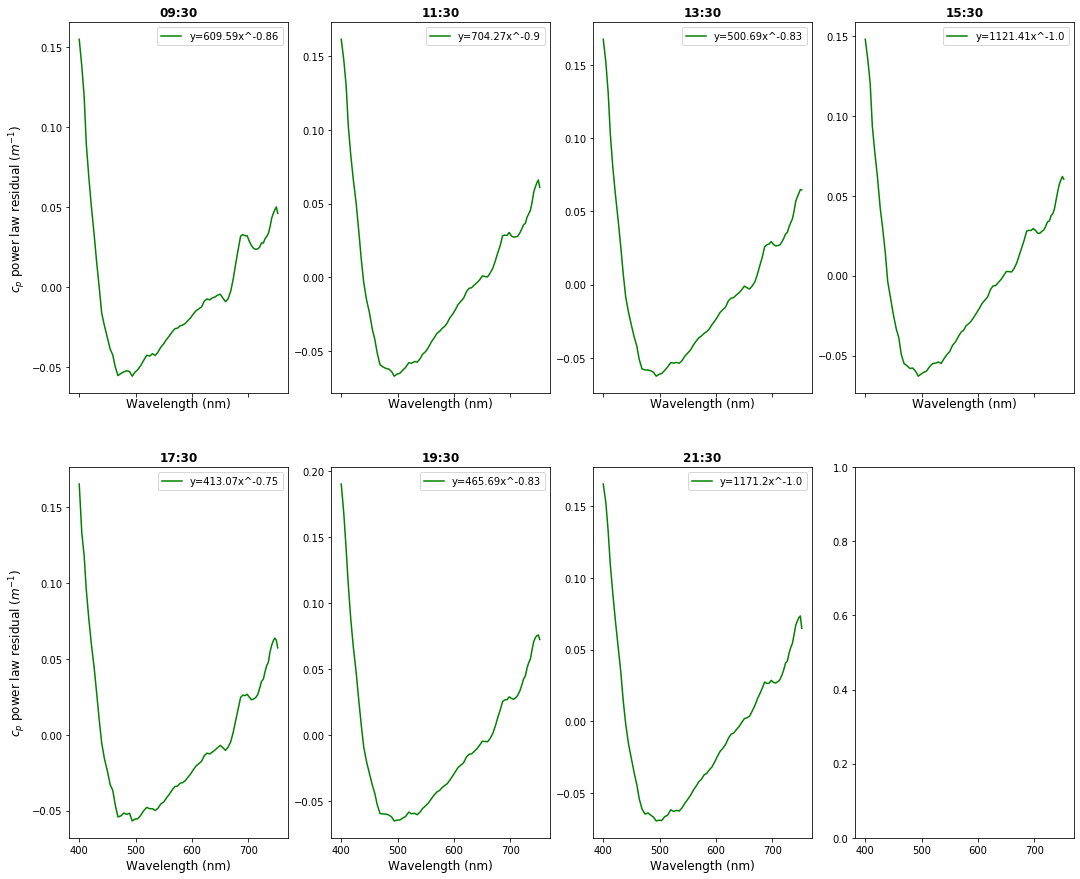

In [159]:
###################### Plots of residuals
fig, axs = plt.subplots(2,4, sharey=False, sharex=True,figsize=(18,15))

k=0
while k<=6:
    for i in range(2):
        for j in range(4):
            
            axs[i][j].plot(a_wav,
                               cp_pl_res[times_[k]],
                               color='green',
                               label='y={}x^{}'.format(round(cp_pl_pars[times_[k]][0],2),round(cp_pl_pars[times_[k]][1],2)))
    
            axs[i][j].set_title(times[k],fontweight='bold')
            axs[i][j].legend()
            
            axs[i][j].set_xlabel('Wavelength (nm)',fontsize=12)
            if k in [0,4]:
                axs[i][j].set_ylabel('$c_p$ power law residual $(m^{-1})$',fontsize=12)
            
                      
            k+=1

plt.suptitle("$c_p$ power law fits \n Removed 430,440,660,670,680")
fig.tight_layout()
plt.show()

# Gamma time-series

Text(0, 0.5, 'Backscatter spectral slope ($\\gamma$)')

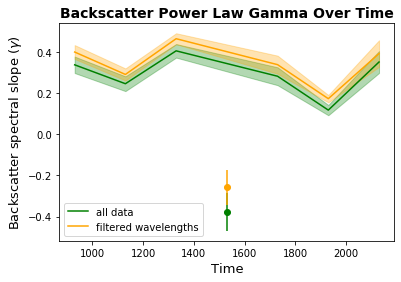

In [174]:
bb_gammas = []
bbx_gammas = []
bb_gammas_stds = []
bbx_gammas_stds = []

for x in times_:
    if x=='1530':
        pass
    else:
        bb_gammas.append(bb_pl_pars[x][1])
        bb_gammas_stds.append(bb_pl_stds[x][1])
        
        bbx_gammas.append(bbx_pl_pars[x][1])
        bbx_gammas_stds.append(bbx_pl_stds[x][1])
        
bb_gammas = [-x for x in bb_gammas]
bbx_gammas = [-x for x in bbx_gammas]

plt.plot([930,1130,1330,1730,1930,2130],bb_gammas,color='green',label='all data')
plt.errorbar(1530,-bb_pl_pars['1530'][1],bb_pl_stds['1530'][1], color='green',marker='o')
plt.fill_between([930,1130,1330,1730,1930,2130],np.add(bb_gammas,bb_gammas_stds),np.subtract(bb_gammas,bb_gammas_stds),color='green',alpha=0.3)

plt.plot([930,1130,1330,1730,1930,2130],bbx_gammas,color='orange',label='filtered wavelengths')
plt.errorbar(1530,-bbx_pl_pars['1530'][1],bbx_pl_stds['1530'][1], color='orange',marker='o')
plt.fill_between([930,1130,1330,1730,1930,2130],np.add(bbx_gammas,bbx_gammas_stds),np.subtract(bbx_gammas,bbx_gammas_stds),color='orange',alpha=0.3)

plt.legend()
plt.title('Backscatter Power Law Gamma Over Time',fontsize=14,fontweight='bold')
plt.xlabel('Time',fontsize=13)
plt.ylabel('Backscatter spectral slope ($\gamma$)',fontsize=13)

Text(0, 0.5, 'Attenuation spectral slope ($\\gamma$)')

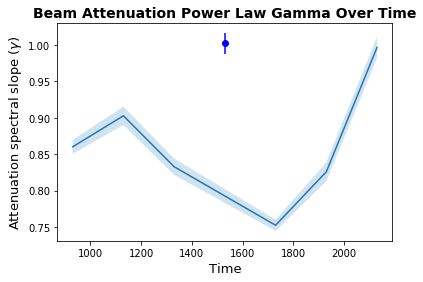

In [168]:
cp_gammas = []
cp_gammas_stds = []

for x in times_:
    if x=='1530':
        pass
    else:
        cp_gammas.append(cp_pl_pars[x][1])
        cp_gammas_stds.append(cp_pl_stds[x][1])
        
cp_gammas = [-x for x in cp_gammas]
    
plt.plot([930,1130,1330,1730,1930,2130],cp_gammas)
plt.errorbar(1530,-cp_pl_pars['1530'][1],cp_pl_stds['1530'][1], color='blue',marker='o')
plt.fill_between([930,1130,1330,1730,1930,2130],np.add(cp_gammas,cp_gammas_stds),np.subtract(cp_gammas,cp_gammas_stds),alpha=0.2)
plt.title('Beam Attenuation Power Law Gamma Over Time',fontsize=14,fontweight='bold')
plt.xlabel('Time',fontsize=13)
plt.ylabel('Attenuation spectral slope ($\gamma$)',fontsize=13)
